# Students

*   João Valério - joao.agostinho@estudiantat.upc.edu
*   Eirik  - grytoyr.grytoyr@estudiantat.upc.edu

# Project Introduction

The main goal of the current project is to develop a model capable of evaluating the text similarity between two sentences.
To accomplish this objective, project development is primarily based on three major components:
*   **Feature Definition**: in which it is intended to represent the sentences in distinct ways so that the subsequent algorithms are able to extract various information about the sentences.
*   **Model Definition**: where various models are considered based on criteria that will be described later. The main purpose of these algorithms is to calculate the similarity of each sentence representation (feature).
*   **Final Model Definition**: This final model has the mission to consider as input the similarity calculations performed by the previously mentioned algorithms and reach a single suitable output value per phrase through a supervised learning process. The pretended similarity is between 0 and 5, with the following meaning:

      5: They are completely equivalent, as they mean the same thing.

      4: They are mostly equivalent, but some unimportant details differ.

      3: They are roughly equivalent, but some important information differs/missing.

      2: They are not equivalent, but share some details.

      1: They are not equivalent, but are on the same topic.

      0: They are on different topics.


Additionally, during these processes, it is intended to explore lexical and syntactic dimensions, separately and combined as well. The results are compared and commented on among the results of the current project and the official results.

Finally, the goodness of the model developed is evaluated by the Pearson correlation. Thus, the decisions regarding the present project are conducted in accordance with this metric.

# Requirements

In this section, all the required libraries for the project's development are imported or installed.

In [ ]:
%pip install textdistance
%pip install Metaphone
%pip install Fuzzy
%pip install soundex
!pip install libindic-soundex
!pip install libindic-utils
!pip install xgboost

from nltk.metrics import jaccard_distance
from textdistance import Hamming, Levenshtein, DamerauLevenshtein, JaroWinkler, NeedlemanWunsch, Gotoh, SmithWaterman
from textdistance import Prefix, Postfix, Length
from textdistance import MRA, Editex
from textdistance import ArithNCD, SqrtNCD, EntropyNCD
from textdistance import LCSSeq, LCSStr
from textdistance import Jaccard, Sorensen, Tversky, Overlap, Cosine, MongeElkan, Bag
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from nltk.stem import PorterStemmer
from scipy.stats import pearsonr
from google.colab import drive
from sklearn.utils import shuffle
from nltk.tokenize import RegexpTokenizer
from metaphone import doublemetaphone
from libindic.soundex import Soundex
import time
import nltk
import pandas as pd
import numpy as np
import spacy
import re
import fuzzy
import xgboost

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Upload Train and Test Data

Firstly, the datasets considered are:
*   Training datasets (2234 observations total):
    1. STS.input.SMTeuroparl.txt
    2. STS.input.MSRvid.txt
    3. STS.input.MSRpar.txt
*   Test datasets (3108 observations total):
    1. STS.input.SMTeuroparl.txt
    2. STS.input.MSRvid.txt
    3. STS.input.MSRpar.txt
    4. STS.input.surprise.SMTnews.txt
    5. STS.input.surprise.OnWN.txt

Furthermore, in each part (training and testing) of the development of the project, the datasets are merged into a single one. This way, the training data is represented by the variable "train_data", while the test data corresponds to the "test_data".

According to the previous configuration, it is considered a single model with the capacity of generalizing the data as a whole.

In [ ]:
# Appending train data
drive.mount('/content/drive')
common_path_train = "/content/drive/MyDrive/Colab Notebooks/IHLT/train/"
common_path_test = "/content/drive/MyDrive/Colab Notebooks/IHLT/test-gold/"

train_data = pd.read_csv(common_path_train + 'STS.input.SMTeuroparl.txt',sep='\t',header=None)
train_data['gs'] = pd.read_csv(common_path_train + 'STS.gs.SMTeuroparl.txt',sep='\t',header=None)


new_dt = pd.read_csv(common_path_train + 'STS.input.MSRvid.txt',sep='\t',header=None)
new_dt['gs'] = pd.read_csv(common_path_train + 'STS.gs.MSRvid.txt',sep='\t',header=None)
train_data = train_data.append(new_dt, ignore_index=True)

new_dt = pd.read_csv(common_path_train + 'STS.input.MSRpar.txt',sep='\t|\t"',header=None)
new_dt['gs'] = pd.read_csv(common_path_train + 'STS.gs.MSRpar.txt',sep='\t',header=None)
train_data = train_data.append(new_dt, ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)

# Appending test data
test_data = pd.read_csv(common_path_test + 'STS.input.SMTeuroparl.txt',sep='\t|\t"',header=None)
test_data['gs'] = pd.read_csv(common_path_test + 'STS.gs.SMTeuroparl.txt',sep='\t',header=None)
SMTeuroparl_lenght = len(test_data)

newdt = pd.DataFrame()
newdt = pd.read_csv(common_path_test + 'STS.input.MSRvid.txt',sep='\t|\t"',header=None)
newdt['gs'] = pd.read_csv(common_path_test + 'STS.gs.MSRvid.txt',sep='\t',header=None)
test_data = test_data.append(newdt, ignore_index=True)
MSRvid_lenght = len(newdt)

newdt = pd.DataFrame()
newdt = pd.read_csv(common_path_test + 'STS.input.MSRpar.txt',sep='\t|\t"',header=None)
newdt['gs'] = pd.read_csv(common_path_test + 'STS.gs.MSRpar.txt',sep='\t',header=None)
test_data = test_data.append(newdt, ignore_index=True)
MSRpar_lenght = len(newdt)

newdt = pd.DataFrame()
newdt = pd.read_csv(common_path_test + 'STS.input.surprise.SMTnews.txt',sep='\t|\t"',header=None)
newdt['gs'] = pd.read_csv(common_path_test + 'STS.gs.surprise.SMTnews.txt',sep='\t',header=None)
test_data = test_data.append(newdt, ignore_index=True)
SMTnews_lenght = len(newdt)

newdt = pd.DataFrame()
newdt = pd.read_csv(common_path_test + 'STS.input.surprise.OnWN.txt',sep='\t|\t"',header=None)
newdt['gs'] = pd.read_csv(common_path_test + 'STS.gs.surprise.OnWN.txt',sep='\t',header=None)
test_data = test_data.append(newdt, ignore_index=True)
OnWN_lenght = len(newdt)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
display(train_data)
display(test_data)

,0,1,gs
0,A young woman is playing a guitar.,A woman cuts up some meat.,0.75
1,All those who are at present engaged in illici...,All those who are currently working to obtain ...,4.40
2,A cat is playing the piano.,A cat is licking its paw.,0.25
3,A dog is playing with a toy.,A dog is eating a doll.,2.25
4,"He wounded a security guard and then fled, sta...",He then stabbed two passersby as he fled along...,3.20
...,...,...,...
2229,Several states and the federal government late...,"Following California's lead, several states an...",4.00
2230,He refused to reveal what percentage of flight...,He refused to say what percentage of domestic ...,3.80
2231,A man is riding a horse by a creek.,A man is riding a horse.,4.00
2232,That made them heavily dependent on loans.,A development which made capital borrowed heav...,3.40


,0,1,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00
...,...,...,...
3103,fill with high spirits,fill with high spirits; fill with optimism.,4.25
3104,The release of pressure built up during a stop...,the terminal forced release of pressure built ...,3.50
3105,(cause to) fall in drops,let or cause to fall in drops.,4.50
3106,The status of being champion.,the status of being a champion.,5.00


# Auxiliar Functions

In the present section, the auxiliary functions to the main one ("get_features") are developed.

In [ ]:
stopWordSet = set(nltk.corpus.stopwords.words('english'))

def clean_Sentence (sentenceList, RemoveStopWords = True, RemovePunctuations = True, ToLower = True):
  # Get the list into lowercase
  if ToLower:
    sentenceList = list(map(lambda word: word.lower(), sentenceList))

  # Filtering the ponctuation and stop words
  if RemoveStopWords and RemovePunctuations:
    sentenceList = list(filter(lambda word : re.search('''[!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~]+''', word) == None and  word not in stopWordSet, sentenceList))
  elif RemovePunctuations:
    sentenceList = list(filter(lambda word : re.search('''[!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~]+''', word) == None, sentenceList))
  elif RemoveStopWords:
    sentenceList = list(filter(lambda word : word not in stopWordSet, sentenceList))
  return sentenceList

def clean_Tuples (tupleList, RemoveStopWords = True, RemovePunctuations = True, ToLower = True):
  # Get the list into lowercase
  if ToLower:
    tupleList = list(map(lambda word: (word[0].lower(), word[1]), tupleList))

  # Filtering the ponctuation and stop words
  if RemoveStopWords and RemovePunctuations:
    tupleList = list(filter(lambda word : re.search('''[!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~]+''', word[0]) == None and  word[0] not in stopWordSet, tupleList))
  elif RemovePunctuations:
    tupleList = list(filter(lambda word : re.search('''[!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~]+''', word[0]) == None, tupleList))
  elif RemoveStopWords:
    tupleList = list(filter(lambda word : word[0] not in stopWordSet, tupleList))
  return tupleList

# Get the list of synsets
def synset_lst(sentence, cleanedText):
  sy_lst = []
  for pair in cleanedText:
    try:
      # Get the synset from a word and appending to the list
      sy_lst.append(nltk.wsd.lesk(sentence, pair[0], pair[1]).name())
    except:
      pass

  return sy_lst

# Mapping the tags between Treebank and WordNet
tag_map = {
  'CC':"none", # coordin. conjunction (and, but, or)  
  'CD':"n", # cardinal number (one, two)             
  'DT':"none", # determiner (a, the)                    
  'EX':"r", # existential ‘there’ (there)           
  'FW':"none", # foreign word (mea culpa)             
  'IN':"r", # preposition/sub-conj (of, in, by)   
  'JJ':"a", # adjective (yellow)                  
  'JJR':"a", # adj., comparative (bigger)          
  'JJS':"a", # adj., superlative (wildest)           
  'LS':"none", # list item marker (1, 2, One)          
  'MD':"none", # modal (can, should)                    
  'NN':"n", # noun, sing. or mass (llama)          
  'NNS':"n", # noun, plural (llamas)                  
  'NNP':"n", # proper noun, sing. (IBM)              
  'NNPS':"n", # proper noun, plural (Carolinas)
  'PDT':"a", # predeterminer (all, both)            
  'POS':"none", # possessive ending (’s )               
  'PRP':"none", # personal pronoun (I, you, he)     
  'PRP$':"none", # possessive pronoun (your, one’s)    
  'RB':"r", # adverb (quickly, never)            
  'RBR':"r", # adverb, comparative (faster)        
  'RBS':"r", # adverb, superlative (fastest)     
  'RP':"a", # particle (up, off)
  'SYM':"none", # symbol (+,%, &)
  'TO':"none", # “to” (to)
  'UH':"none", # interjection (ah, oops)
  'VB':"v", # verb base form (eat)
  'VBD':"v", # verb past tense (ate)
  'VBG':"v", # verb gerund (eating)
  'VBN':"v", # verb past participle (eaten)
  'VBP':"v", # verb non-3sg pres (eat)
  'VBZ':"v", # verb 3sg pres (eats)
  'WDT':"none", # wh-determiner (which, that)
  'WP':"none", # wh-pronoun (what, who)
  'WP$':"none", # possessive (wh- whose)
  'WRB':"none", # wh-adverb (how, where)
}

def get_pos_tags (sentenceList):
  sentenceList = nltk.pos_tag(sentenceList)
  return [(pair[0], tagger(pair[1])) for pair in sentenceList]

def stemmer (sentenceList):
  # Considering that similar words have almost the same meaning in any form
  return list(map(lambda word: PorterStemmer().stem(word), sentenceList))

# Transforming the tag of the words according to the tag_map
def tagger(tag):
  if tag in tag_map.keys():
    return tag_map[tag] 
  return "none"

def lematize(pair):
  return [lemmatize_Pair(pair) for pair in pair]

# Lemmatizing the words according to the tag_map
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize_Pair(p):
  try:

    return wnl.lemmatize(p[0], pos=p[1])
  except:
    return p[0]

def get_NE_Chunck(tokens):
  # Chunck
    tagsText = nltk.pos_tag(tokens)
    chunckText1 = nltk.tree2conlltags(nltk.ne_chunk(tagsText))
    i = 0
    NERCText1 = []
    while i < len(chunckText1) - 1:
      NERCText1.append(chunckText1[i][0])
      if chunckText1[i][1+1] != "O" and chunckText1[i][1][2:] == chunckText1[i+1][1][2:]:
        NERCText1[-1] += (" " + (chunckText1[i+1][0]))
        i += 1
      i += 1
    return(NERCText1)

# Get the sentences represented as a n-gram
def get_n_grams(sentence, n):
  sentences = sentence.lower()
  n_grams_list = []
  ini = 0
  end = n
  while end < len(sentence):
    n_grams_list.append(sentence[ini:end])
    ini = end
    end += n

  return n_grams_list

# Tokenize the sentences
def tokenize(sentence):
  return nltk.word_tokenize(sentence)


# Get the phonemas
def get_phoneme(sentenceList):
  phoneme_list_DMetaphone = []
  phoneme_list_nysiis = []
  phoneme_list_soundex = []
  for wd in sentenceList:
    for ph in doublemetaphone(wd):
      if ph != '': phoneme_list_DMetaphone.append(ph)
    ph = fuzzy.nysiis(wd)
    if ph != '': phoneme_list_nysiis.append(ph)
    ph = Soundex().soundex(wd)
    if ph != '': phoneme_list_soundex.append(ph)
  
  return phoneme_list_DMetaphone, phoneme_list_nysiis, phoneme_list_soundex

# Features

In order to represent each sentence in distict forms, 13 total features are considered, in which 9 (69%) are lexical and 4 (31%) are syntatic.

**Lexical Features**:
*   **sentence**: the whole sentence is represented a single string.
*   **token**: the previous sentence is tokenized according to nltk.tokenize.RegexpTokenizer, in which each word is a single string.
*   **stem**: the previously tokenized words are stemmed.
*   **n-grams**: From the sentences, it is formed a contiguous sequence of n symbols. In the current project, n assumed values from 2 to 4 (inclusive).
*   **phoneme**: Where the smallest units from the tokenizes sentences are obtained. These, are directly related to the sound produced by the spelling of the word. In this process 3 distinct algorithms were used: DMetaphone, Nysiis and Soundex.

**Syntatic Features**:
*   **synset**: According to the tags, get the main synset of each word.
*   **chunck**: According to the tags, get the chuncked words related to the NEs.
*   **lemma**: According to the tags, get the canonical form of a word.
*   **triple**: According to the tags, the sentences to be compared are expanded with tags and representations of their dependencies.

Furthermore, the previous features are saved in the dataframes:
*   **train_featuresText1**: training features from column 0 of "train_data" dataframe.
*   **train_featuresText2**: training features from column 1 of "train_data" dataframe.
*   **test_featuresText1**: testing features from column 0 of "test_data" dataframe.
*   **test_featuresText2**: testing features from column 1 of "test_data" dataframe.

In [ ]:
# Feature Dataframes
train_featuresText1 = pd.DataFrame()
train_featuresText2 = pd.DataFrame()
test_featuresText1 = pd.DataFrame()
test_featuresText2 = pd.DataFrame()
feature_list = ['sentence', 'token', 'stem', '2ngram', '3ngram', '4ngram', 'phoneme_nysiis', 'phoneme_soundex', 'chunck', 'lemma', 'synset',  'triple', 'phoneme_DMetaphone']
for name in feature_list:
  train_featuresText1[name] = ''
  train_featuresText2[name] = ''
  test_featuresText1[name] = ''
  test_featuresText2[name] = ''
display(train_featuresText1)
display(train_featuresText2)
display(test_featuresText1)
display(test_featuresText2)

# Save the features from the train or test data
def save_features(id, mode, sentenceText1, sentenceText2, cleanedtokenText1, cleanedtokenText2, stemText1, stemText2, NERCText1, NERCText2, lemmaText1, lemmaText2,
                  synsetText1, synsetText2, ngrams_2_Text1, ngrams_2_Text2, ngrams_3_Text1, ngrams_3_Text2, ngrams_4_Text1, ngrams_4_Text2, tripleText1, tripleText2,
                  phoneme_DMetaphone_Text1, phoneme_DMetaphone_Text2, phoneme_nysiis_Text1, phoneme_nysiis_Text2, phoneme_soundex_Text1, phoneme_soundex_Text2):
  
  if (mode == 'train'):
    train_featuresText1.at[id, 'sentence'], train_featuresText2.at[id, 'sentence'] = sentenceText1, sentenceText2
    train_featuresText1.at[id, 'token'], train_featuresText2.at[id, 'token'] = cleanedtokenText1, cleanedtokenText2
    train_featuresText1.at[id, 'stem'], train_featuresText2.at[id, 'stem'] = stemText1, stemText2
    train_featuresText1.at[id, 'chunck'], train_featuresText2.at[id, 'chunck'] = NERCText1, NERCText2
    train_featuresText1.at[id, 'lemma'], train_featuresText2.at[id, 'lemma'] = lemmaText1, lemmaText2
    train_featuresText1.at[id, 'synset'], train_featuresText2.at[id, 'synset'] = synsetText1, synsetText2
    train_featuresText1.at[id, '2ngram'], train_featuresText2.at[id, '2ngram'] = ngrams_2_Text1, ngrams_2_Text2
    train_featuresText1.at[id, '3ngram'], train_featuresText2.at[id, '3ngram'] = ngrams_3_Text1, ngrams_3_Text2
    train_featuresText1.at[id, '4ngram'], train_featuresText2.at[id, '4ngram'] = ngrams_4_Text1, ngrams_4_Text2
    train_featuresText1.at[id, 'triple'], train_featuresText2.at[id, 'triple'] = tripleText1, tripleText2
    train_featuresText1.at[id, 'phoneme_DMetaphone'], train_featuresText2.at[id, 'phoneme_DMetaphone'] = phoneme_DMetaphone_Text1, phoneme_DMetaphone_Text2
    train_featuresText1.at[id, 'phoneme_nysiis'], train_featuresText2.at[id, 'phoneme_nysiis'] = phoneme_nysiis_Text1, phoneme_nysiis_Text2
    train_featuresText1.at[id, 'phoneme_soundex'], train_featuresText2.at[id, 'phoneme_soundex'] = phoneme_soundex_Text1, phoneme_soundex_Text2
  if (mode == 'test'):
    test_featuresText1.at[id, 'sentence'], test_featuresText2.at[id, 'sentence'] = sentenceText1, sentenceText2
    test_featuresText1.at[id, 'token'], test_featuresText2.at[id, 'token'] = cleanedtokenText1, cleanedtokenText2
    test_featuresText1.at[id, 'stem'], test_featuresText2.at[id, 'stem'] = stemText1, stemText2
    test_featuresText1.at[id, 'chunck'], test_featuresText2.at[id, 'chunck'] = NERCText1, NERCText2
    test_featuresText1.at[id, 'lemma'], test_featuresText2.at[id, 'lemma'] = lemmaText1, lemmaText2
    test_featuresText1.at[id, 'synset'], test_featuresText2.at[id, 'synset'] = synsetText1, synsetText2
    test_featuresText1.at[id, '2ngram'], test_featuresText2.at[id, '2ngram'] = ngrams_2_Text1, ngrams_2_Text2
    test_featuresText1.at[id, '3ngram'], test_featuresText2.at[id, '3ngram'] = ngrams_3_Text1, ngrams_3_Text2
    test_featuresText1.at[id, '4ngram'], test_featuresText2.at[id, '4ngram'] = ngrams_4_Text1, ngrams_4_Text2
    test_featuresText1.at[id, 'triple'], test_featuresText2.at[id, 'triple'] = tripleText1, tripleText2
    test_featuresText1.at[id, 'phoneme_DMetaphone'], test_featuresText2.at[id, 'phoneme_DMetaphone'] = phoneme_DMetaphone_Text1, phoneme_DMetaphone_Text2
    test_featuresText1.at[id, 'phoneme_nysiis'], test_featuresText2.at[id, 'phoneme_nysiis'] = phoneme_nysiis_Text1, phoneme_nysiis_Text2
    test_featuresText1.at[id, 'phoneme_soundex'], test_featuresText2.at[id, 'phoneme_soundex'] = phoneme_soundex_Text1, phoneme_soundex_Text2

,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone


,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone


,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone


,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone


# Get Features

In [ ]:
def get_features(mode, data):

  for id in range(len(data[0][:])):

    ################## Model - Sentence ##################

    sentenceText1, sentenceText2 = data.loc[id,0], data.loc[id,1]

    ################## Model - Sentence ##################


    
    ################## Model - Tokens ##################

    tokenizer = RegexpTokenizer(r'\w+')
    tokenText1, tokenText2 = tokenizer.tokenize(sentenceText1), tokenizer.tokenize(sentenceText2)
    cleanedtokenText1, cleanedtokenText2 = clean_Sentence(tokenText1), clean_Sentence(tokenText2)
    
    ################## Model - Tokens ##################



    ################## Model - Stem ##################

    stemText1, stemText2 = stemmer(tokenText1), stemmer(tokenText2)
    stemText1, stemText2 = clean_Sentence(stemText1), clean_Sentence(stemText2)
    
    ################## Model - Stem ##################


    
    ################## Model - Chunck ##################

    NERCText1, NERCText2 = get_NE_Chunck(tokenText1), get_NE_Chunck(tokenText2)
    NERCText1, NERCText2 = clean_Sentence(NERCText1), clean_Sentence(NERCText2)
    
    ################## Model - Chunck ##################
    


    ################## Model - Lemma ##################

    tagsText1, tagsText2 = get_pos_tags(tokenText1), get_pos_tags(tokenText2)
    CleanedtaggedText1, CleanedtaggedText2 = clean_Tuples(tagsText1), clean_Tuples(tagsText2)
    lemmaText1, lemmaText2 = lematize(CleanedtaggedText1), lematize(CleanedtaggedText2)
    
    ################## Model - Lemma ##################


    ################## Model - Synsets ##################

    synsetText1, synsetText2 = synset_lst(cleanedtokenText1, CleanedtaggedText1), synset_lst(cleanedtokenText2, CleanedtaggedText2)

    ################## Model - Synsets ##################

    

    ################## Model - ngrams ##################

    ngrams_2_Text1, ngrams_2_Text2 = get_n_grams(sentenceText1, 2), get_n_grams(sentenceText2, 2)
    ngrams_3_Text1, ngrams_3_Text2 = get_n_grams(sentenceText1, 3), get_n_grams(sentenceText2, 3)
    ngrams_4_Text1, ngrams_4_Text2 = get_n_grams(sentenceText1, 4), get_n_grams(sentenceText2, 4)

    ################## Model - ngrams ##################



    ################## Model - Triples as individual tokens ##################

    dependesies1, dependesies2 = nlp(sentenceText1), nlp(sentenceText2)
    tripleText1, tripleText2 = np.array([[token.text.lower(), token.tag_, token.dep_] for token in dependesies1]), np.array([[token.text.lower(), token.tag_, token.dep_] for token in dependesies2])
    tripleText1, tripleText2 = tripleText1.reshape(tripleText1.shape[0]*tripleText1.shape[1]), tripleText2.reshape(tripleText2.shape[0]*tripleText2.shape[1])
    tripleText1, tripleText2 = clean_Sentence(tripleText1), clean_Sentence(tripleText2)

    ################## Model - Triples as individual tokens ##################



    ################## Model - phonetic ##################

    phoneme_DMetaphone_Text1, phoneme_nysiis_Text1, phoneme_soundex_Text1 = get_phoneme(tokenText1)
    phoneme_DMetaphone_Text2, phoneme_nysiis_Text2, phoneme_soundex_Text2 = get_phoneme(tokenText2)

    ################## Model - phonetic ##################


    # Saving the features
    save_features(id, mode, sentenceText1, sentenceText2, tokenText1, tokenText2, stemText1, stemText2, NERCText1, NERCText2, lemmaText1, lemmaText2,
                  synsetText1, synsetText2, ngrams_2_Text1, ngrams_2_Text2, ngrams_3_Text1, ngrams_3_Text2, ngrams_4_Text1, ngrams_4_Text2, tripleText1, tripleText2,
                   phoneme_DMetaphone_Text1, phoneme_DMetaphone_Text2, phoneme_nysiis_Text1, phoneme_nysiis_Text2, phoneme_soundex_Text1, phoneme_soundex_Text2)

In [ ]:
get_features('train', train_data)

In [ ]:
display(train_featuresText1)

,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone
0,A young woman is playing a guitar.,"[A, young, woman, is, playing, a, guitar]","[young, woman, play, guitar]","[A , yo, un, g , wo, ma, n , is, p, la, yi, n...","[A y, oun, g w, oma, n i, s p, lay, ing, a , ...","[A yo, ung , woma, n is, pla, ying, a g, uita]","[YANG, WANAN, PLYANG, GATAR]","[A, y52, w5, i2, p452, a, g36]","[young, woman, playing]","[young, woman, play, guitar]","[young.a.01, womanhood.n.02, toy.v.02, guitar....","[dt, det, young, jj, amod, woman, nn, nsubj, v...","[A, ANK, AMN, FMN, AS, PLNK, A, KTR]"
1,All those who are at present engaged in illici...,"[All, those, who, are, at, present, engaged, i...","[present, engag, illicit, work, would, obtain,...","[Al, l , th, os, e , wh, o , ar, e , at, p, r...","[All, th, ose, wh, o a, re , at , pre, sen, ...","[All , thos, e wh, o ar, e at, pre, sent, en...","[AL, TAS, W, AR, AT, PRASAD, ENGAGAD, IN, ILAC...","[A4, t2, w, a6, a3, p6253, e523, i5, i423, w62...","[present, engaged, illicit, work, would, obtai...","[present, engage, illicit, work, would, obtain...","[present.a.02, hire.v.01, illicit.a.01, workpl...","[pdt, predet, dt, nsubj, wp, nsubj, vbp, relcl...","[AL, 0S, TS, A, AR, AT, PRSNT, ANKJT, ANKKT, A..."
2,A cat is playing the piano.,"[A, cat, is, playing, the, piano]","[cat, play, piano]","[A , ca, t , is, p, la, yi, ng, t, he, p, i...","[A c, at , is , pla, yin, g t, he , pia]","[A ca, t is, pla, ying, the, pia]","[CAT, PLYANG, T, PAN]","[A, c3, i2, p452, t, p5]","[cat, playing]","[cat, play, piano]","[kat.n.01, toy.v.02, piano.n.02]","[dt, det, cat, nn, nsubj, vbz, aux, playing, v...","[A, KT, AS, PLNK, 0, T, PN]"
3,A dog is playing with a toy.,"[A, dog, is, playing, with, a, toy]","[dog, play, toy]","[A , do, g , is, p, la, yi, ng, w, it, h , a...","[A d, og , is , pla, yin, g w, ith, a , toy]","[A do, g is, pla, ying, wit, h a ]","[DAG, PLYANG, WATH, TY]","[A, d2, i2, p452, w3, a, t]","[dog, playing]","[dog, play, toy]","[pawl.n.01, toy.v.02, toy_dog.n.01]","[dt, det, dog, nn, nsubj, vbz, aux, playing, v...","[A, TK, AS, PLNK, A0, FT, A, T]"
4,"He wounded a security guard and then fled, sta...","[He, wounded, a, security, guard, and, then, f...","[wound, secur, guard, fled, stab, two, passers...","[He, w, ou, nd, ed, a, s, ec, ur, it, y , g...","[He , wou, nde, d a, se, cur, ity, gu, ard, ...","[He w, ound, ed a, sec, urit, y gu, ard , and...","[H, WANDAD, SACARATY, GAD, AD, TAN, FLAD, STAB...","[H, w53, a, s263, g63, a53, t5, f43, s3152, t,...","[wounded, security, guard, fled, stabbing, two...","[wound, security, guard, flee, stab, two, pass...","[injure.v.01, security.n.06, guard.n.05, flee....","[prp, nsubj, wounded, vbd, root, dt, det, secu...","[H, ANTT, FNTT, A, SKRT, KRT, ANT, 0N, TN, FLT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,Several states and the federal government late...,"[Several, states, and, the, federal, governmen...","[sever, state, feder, govern, later, pass, sim...","[Se, ve, ra, l , st, at, es, a, nd, t, he, ...","[Sev, era, l s, tat, es , and, th, e f, ede, ...","[Seve, ral , stat, es a, nd t, he f, eder, al ...","[SAFARAL, STAT, AD, T, FADARAL, GAVARNAD, LATA...","[S164, s32, a53, t, f364, g1653, l36, p23, s54...","[several, states, federal, government, later, ...","[several, state, federal, government, later, p...","[state_of_matter.n.01, federal.a.04, politics....","[several, jj, amod, states, nns, nsubj, cc, cc...","[SFRL, STTS, ANT, 0, T, FTRL, KFRNMNT, LTR, PS..."
2230,He refused to reveal what percentage of flight...,"[He, refused, to, reveal, what, percentage, of...","[refus, reveal, percentag, flight, carri, sky,...","[He, r, ef, us, ed, t, o , re, ve, al, w, h...","[He , ref, use, d t, o r, eve, al , wha, t p, ...","[He r, efus, ed t, o re, veal, wha, t pe, rce...","[H, RAFASAD, T, RAFAL, WAT, PARCANTAG, OF, FLA...","[H, r123, t, r14, w3, p62532, o1, f4232, c63, ...","[refu

In [ ]:
display(train_featuresText2)

,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone
0,A woman cuts up some meat.,"[A, woman, cuts, up, some, meat]","[woman, cut, meat]","[A , wo, ma, n , cu, ts, u, p , so, me, m, ea]","[A w, oma, n c, uts, up, so, me , mea]","[A wo, man , cuts, up , some, mea]","[WANAN, CAT, UP, SAN, MAT]","[A, w5, c32, u1, s5, m3]","[woman, cuts]","[woman, cut, meat]","[womanhood.n.02, write_out.v.02, meat.n.01]","[dt, det, woman, nn, nsubj, cuts, vbz, root, r...","[A, AMN, FMN, KTS, AP, SM, MT]"
1,All those who are currently working to obtain ...,"[All, those, who, are, currently, working, to,...","[current, work, obtain, undeclar, employ, dece...","[Al, l , th, os, e , wh, o , ar, e , cu, rr, e...","[All, th, ose, wh, o a, re , cur, ren, tly, ...","[All , thos, e wh, o ar, e cu, rren, tly , wor...","[AL, TAS, W, AR, CARANTLY, WARCANG, T, OBTAN, ...","[A4, t2, w, a6, c6534, w6252, t, o135, a5, u53...","[currently, working, obtain, undeclared, emplo...","[currently, work, obtain, undeclared, employme...","[presently.r.02, work.v.27, receive.v.02, unde...","[pdt, predet, dt, root, wp, nsubj, vbp, aux, c...","[AL, 0S, TS, A, AR, KRNTL, ARKNK, FRKNK, T, AP..."
2,A cat is licking its paw.,"[A, cat, is, licking, its, paw]","[cat, lick, paw]","[A , ca, t , is, l, ic, ki, ng, i, ts, p, aw]","[A c, at , is , lic, kin, g i, ts , paw]","[A ca, t is, lic, king, its, paw]","[CAT, LACANG, IT, P]","[A, c3, i2, l252, i32, p]","[cat, licking]","[cat, lick, paw]","[kat.n.01, solve.v.01, paw.n.01]","[dt, det, cat, nn, nsubj, vbz, aux, licking, v...","[A, KT, AS, LKNK, ATS, P, PF]"
3,A dog is eating a doll.,"[A, dog, is, eating, a, doll]","[dog, eat, doll]","[A , do, g , is, e, at, in, g , a , do, ll]","[A d, og , is , eat, ing, a , dol]","[A do, g is, eat, ing , a do]","[DAG, EATANG, DAL]","[A, d2, i2, e352, a, d4]","[dog, eating]","[dog, eat, doll]","[pawl.n.01, feed.v.06, doll.n.01]","[dt, det, dog, nn, nsubj, vbz, aux, eating, vb...","[A, TK, AS, ATNK, A, TL]"
4,He then stabbed two passersby as he fled along...,"[He, then, stabbed, two, passersby, as, he, fl...","[stab, two, passersbi, fled, along, promenad, ...","[He, t, he, n , st, ab, be, d , tw, o , pa, s...","[He , the, n s, tab, bed, tw, o p, ass, ers, ...","[He t, hen , stab, bed , two , pass, ersb, y a...","[H, TAN, STABAD, TW, PASARSBY, H, FLAD, ALANG,...","[H, t5, s313, t, p2621, a2, h, f43, a452, a, p...","[stabbed, two, passersby, fled, along, promenade]","[stab, two, passersby, flee, along, promenade,...","[stab.v.02, deuce.n.04, flee.v.01, promenade.n...","[prp, nsubj, rb, advmod, stabbed, vbd, root, t...","[H, 0N, TN, STPT, T, PSRSP, AS, H, FLT, ALNK, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,"Following California's lead, several states an...","[Following, California, s, lead, several, stat...","[follow, california, lead, sever, state, feder...","[Fo, ll, ow, in, g , Ca, li, fo, rn, ia, 's, ...","[Fol, low, ing, Ca, lif, orn, ia', s l, ead, ...","[Foll, owin, g Ca, lifo, rnia, 's l, ead,, se...","[FALANG, CALAFARN, LAD, SAFARAL, STAT, AD, T, ...","[F452, C4165, s, l3, s164, s32, a53, t, f364, ...","[following, california, lead, several, states,...","[follow, california, lead, several, state, fed...","[watch.v.02, california.n.01, state_of_matter....","[following, vbg, prep, california, nnp, poss, ...","[FLNK, KLFRN, S, LT, SFRL, STTS, ANT, 0, T, FT..."
2230,He refused to say what percentage of domestic ...,"[He, refused, to, say, what, percentage, of, d...","[refus, say, percentag, domest, flight, secur,...","[He, r, ef, us, ed, t, o , sa, y , wh, at, ...","[He , ref, use, d t, o s, ay , wha, t p, erc, ...","[He r, efus, ed t, o sa, y wh, at p, erce, nta...","[H, RAFASAD, T, SY, WAT, PARCANTAG, OF, DANAST...","[H, r123, t, s, w3, p62532, o1, d5232, f4232, ...","[refused, say, percentage, domestic, flights, ...","[refuse, say, percentage, domestic, flight, se...","[resist.v.05, suppose.v.01, share.n.01

In [ ]:
get_features('test', test_data)

In [ ]:
display(test_featuresText1)

,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone
0,The leaders have now been given a new chance a...,"[The, leaders, have, now, been, given, a, new,...","[leader, given, new, chanc, let, us, hope, seiz]","[Th, e , le, ad, er, s , ha, ve, n, ow, b, e...","[The, le, ade, rs , hav, e n, ow , bee, n g, ...","[The , lead, ers , have, now, bee, n gi, ven...","[T, LADAR, HAV, N, BAN, GAVAN, N, CANC, AD, LA...","[T, l362, h1, n, b5, g15, a, n, c52, a53, l3, ...","[leaders, given, new, chance, let, us, hope, s...","[leader, give, new, chance, let, us, hope, seize]","[leadership.n.02, yield.v.01, new.a.06, prospe...","[dt, det, leaders, nns, nsubjpass, vbp, aux, r...","[0, T, LTRS, HF, N, NF, PN, JFN, KFN, A, N, NF..."
1,Amendment No 7 proposes certain changes in the...,"[Amendment, No, 7, proposes, certain, changes,...","[amend, 7, propos, certain, chang, refer, para...","[Am, en, dm, en, t , No, 7, p, ro, po, se, s...","[Ame, ndm, ent, No, 7 , pro, pos, es , cer, ...","[Amen, dmen, t No, 7 p, ropo, ses , cert, ain...","[ANANDNAD, N, PRAPAS, CARTAN, CANG, IN, T, RAF...","[A5353, N, 70000000, p612, c635, c52, i5, t, r...","[amendment, 7, proposes, certain, changes, ref...","[amendment, 7, propose, certain, change, refer...","[amendment.n.02, seven.n.01, propose.v.05, cer...","[amendment, nn, compound, dt, compound, 7, cd,...","[AMNTMNT, N, PRPSS, SRTN, XNJS, XNKS, AN, 0, T..."
2,Let me remind you that our allies include ferv...,"[Let, me, remind, you, that, our, allies, incl...","[let, remind, alli, includ, fervent, support, ...","[Le, t , me, r, em, in, d , yo, u , th, at, ...","[Let, me, re, min, d y, ou , tha, t o, ur , ...","[Let , me r, emin, d yo, u th, at o, ur a, lli...","[LAT, M, RANAD, Y, TAT, OAR, ALY, INCLAD, FARV...","[L3, m, r53, y, t3, o6, a42, i5243, f6153, s16...","[let, remind, allies, include, fervent, suppor...","[let, remind, ally, include, fervent, supporte...","[permit.v.01, remind.v.01, ally.n.02, include....","[let, vb, root, prp, nsubj, remind, vb, ccomp,...","[LT, M, RMNT, A, 0T, TT, AR, ALS, ANKLT, FRFNT..."
3,The vote will take place today at 5.30 p.m.,"[The, vote, will, take, place, today, at, 5, 3...","[vote, take, place, today, 5, 30, p]","[Th, e , vo, te, w, il, l , ta, ke, p, la, c...","[The, vo, te , wil, l t, ake, pl, ace, to, ...","[The , vote, wil, l ta, ke p, lace, tod, ay ...","[T, VAT, WAL, TAC, PLAC, TADY, AT, P, M]","[T, v3, w4, t2, p42, t3, a3, 50000000, 3000000...","[vote, take, place, today, 5, 30, p]","[vote, take, place, today, 5, 30, p]","[vote.n.05, take.v.24, topographic_point.n.01,...","[dt, det, vote, nn, nsubj, md, aux, take, vb, ...","[0, T, FT, AL, FL, TK, PLS, TT, AT, P, M]"
4,"The fishermen are inactive, tired and disappoi...","[The, fishermen, are, inactive, tired, and, di...","[fishermen, inact, tire, disappoint]","[Th, e , fi, sh, er, me, n , ar, e , in, ac, t...","[The, fi, she, rme, n a, re , ina, cti, ve,, ...","[The , fish, erme, n ar, e in, acti, ve, , tir...","[T, FASARNAN, AR, INACTAV, TARAD, AD, DASAPANTAD]","[T, f265, a6, i5231, t63, a53, d2153]","[fishermen, inactive, tired]","[fisherman, inactive, tired, disappointed]","[fisherman.n.01, passive.a.01, tired.a.01]","[dt, det, fishermen, nns, nsubj, vbp, root, in...","[0, T, FXRMN, AR, ANKTF, TRT, ANT, TSPNTT]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,fill with high spirits,"[fill, with, high, spirits]","[fill, high, spirit]","[fi, ll, w, it, h , hi, gh, s, pi, ri]","[fil, l w, ith, hi, gh , spi, rit]","[fill, wit, h hi, gh s, piri]","[FAL, WATH, HAGH, SPARAT]","[f4, w3, h2, s1632]","[fill, high]","[fill, high, spirit]","[filling.n.01, high.a.04, spirit.n.04]","[fill, vb, root, prep, high, jj, amod, spirits...","[FL, A0, FT, HH, SPRTS]"
3104,The release of pressure built up during a stop...,"[The, release, of, pressure, built, up, during...","[releas, pressur, built, dure, stop, conson]","[Th, e , re, le, as, e , of, p, re, ss, ur

In [ ]:
display(test_featuresText2)

,sentence,token,stem,2ngram,3ngram,4ngram,phoneme_nysiis,phoneme_soundex,chunck,lemma,synset,triple,phoneme_DMetaphone
0,The leaders benefit aujourd' hui of a new luck...,"[The, leaders, benefit, aujourd, hui, of, a, n...","[leader, benefit, aujourd, hui, new, luck, let...","[Th, e , le, ad, er, s , be, ne, fi, t , au, j...","[The, le, ade, rs , ben, efi, t a, ujo, urd, ...","[The , lead, ers , bene, fit , aujo, urd', hu...","[T, LADAR, BANAFAT, AJAD, H, OF, N, LAC, AD, L...","[T, l362, b513, a263, h, o1, a, n, l2, a53, l3...","[leaders, benefit, aujourd, hui, new, luck, le...","[leader, benefit, aujourd, hui, new, luck, let...","[leadership.n.02, profit.v.01, new.a.06, luck....","[dt, det, leaders, nns, nsubj, benefit, vbp, r...","[0, T, LTRS, PNFT, AJRT, AHRT, H, AF, A, N, NF..."
1,Amendment No 7 is proposing certain changes in...,"[Amendment, No, 7, is, proposing, certain, cha...","[amend, 7, propos, certain, chang, refer, para...","[Am, en, dm, en, t , No, 7, i, s , pr, op, o...","[Ame, ndm, ent, No, 7 , is , pro, pos, ing, ...","[Amen, dmen, t No, 7 i, s pr, opos, ing , cer...","[ANANDNAD, N, PRAPASANG, CARTAN, CANG, IN, T, ...","[A5353, N, 70000000, i2, p61252, c635, c52, i5...","[amendment, 7, proposing, certain, changes, re...","[amendment, 7, propose, certain, change, refer...","[amendment.n.02, seven.n.01, propose.v.05, cer...","[amendment, nn, compound, nn, compound, 7, cd,...","[AMNTMNT, N, AS, PRPSNK, SRTN, XNJS, XNKS, AN,..."
2,I would like to remind you that among our alli...,"[I, would, like, to, remind, you, that, among,...","[would, like, remind, among, alli, strong, thi...","[I , wo, ul, d , li, ke, t, o , re, mi, nd, ...","[I w, oul, d l, ike, to, re, min, d y, ou , ...","[I wo, uld , like, to , remi, nd y, ou t, hat...","[WALD, LAC, T, RANAD, Y, TAT, ANANG, OAR, ALY,...","[I, w43, l2, t, r53, y, t3, a52, o6, a42, t6, ...","[would, like, remind, among, allies, strong]","[would, like, remind, among, ally, strong, tax]","[wish.v.02, remind.v.01, ally.n.02, potent.a.0...","[prp, nsubj, would, md, aux, like, vb, root, a...","[A, ALT, FLT, LK, T, RMNT, A, 0T, TT, AMNK, AR..."
3,The vote will take place at 5.30pm,"[The, vote, will, take, place, at, 5, 30pm]","[vote, take, place, 5, 30pm]","[Th, e , vo, te, w, il, l , ta, ke, p, la, c...","[The, vo, te , wil, l t, ake, pl, ace, at, ...","[The , vote, wil, l ta, ke p, lace, at , 5.30]","[T, VAT, WAL, TAC, PLAC, AT, PN]","[T, v3, w4, t2, p42, a3, 50000000, 31500000]","[vote, take, place, 5]","[vote, take, place, 5, 30pm]","[vote.n.05, take.v.24, topographic_point.n.01,...","[dt, det, vote, nn, nsubj, md, aux, take, vb, ...","[0, T, FT, AL, FL, TK, PLS, AT, PM]"
4,"The fishermen are inactive, tired and disappoi...","[The, fishermen, are, inactive, tired, and, di...","[fishermen, inact, tire, disappoint]","[Th, e , fi, sh, er, me, n , ar, e , in, ac, t...","[The, fi, she, rme, n a, re , ina, cti, ve,, ...","[The , fish, erme, n ar, e in, acti, ve, , tir...","[T, FASARNAN, AR, INACTAV, TARAD, AD, DASAPANTAD]","[T, f265, a6, i5231, t63, a53, d2153]","[fishermen, inactive, tired]","[fisherman, inactive, tired, disappointed]","[fisherman.n.01, passive.a.01, tired.a.01]","[dt, det, fishermen, nns, nsubj, vbp, root, in...","[0, T, FXRMN, AR, ANKTF, TRT, ANT, TSPNTT]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,fill with high spirits; fill with optimism.,"[fill, with, high, spirits, fill, with, optimism]","[fill, high, spirit, fill, optim]","[fi, ll, w, it, h , hi, gh, s, pi, ri, ts, ;...","[fil, l w, ith, hi, gh , spi, rit, s; , fil, ...","[fill, wit, h hi, gh s, piri, ts; , fill, wi...","[FAL, WATH, HAGH, SPARAT, FAL, WATH, OPTANASN]","[f4, w3, h2, s1632, f4, w3, o13525]","[fill, high, spirits, fill]","[fill, high, spirit, fill, optimism]","[filling.n.01, high.a.04, spirit.n.04, satiate...","[fill, vb, root, prep, high, jj, amod, spirits...","[FL, A0, FT, HH, SPRTS, FL, A0, FT, APTMSM]"
3104,the terminal forced release of pressure built ...,"[the, terminal

# Similarity Metrics

**SIMILARITY METRICS SELECTION**

As explained previously, the following metrics have the objective of calculating the similarity between two sentences according to the features considered. This way, each model is applied to all the features of the observations.

It is also critical that the models considered to measure the similarities are distinct and diverse, as it was intended to get the maximum amount of information representation through the features. Therefore, the six large groups of text distance metrics considered are:

*   Edit-based
*   Token-based
*   Sequence-based
*   Compression-based
*   Simple
*   Hybrid

An important note is that phonetic algorithms are not considered similarity metrics. Instead, they were used, as previously demonstrated, in the feature space (DMetaphone, Nysiis, and Soundex), because the validation correlation is significantly better and the time complexity is lower.

The respective descriptions, advantages, disadvantages and the algorithms considered of the categories are presented in the following table:

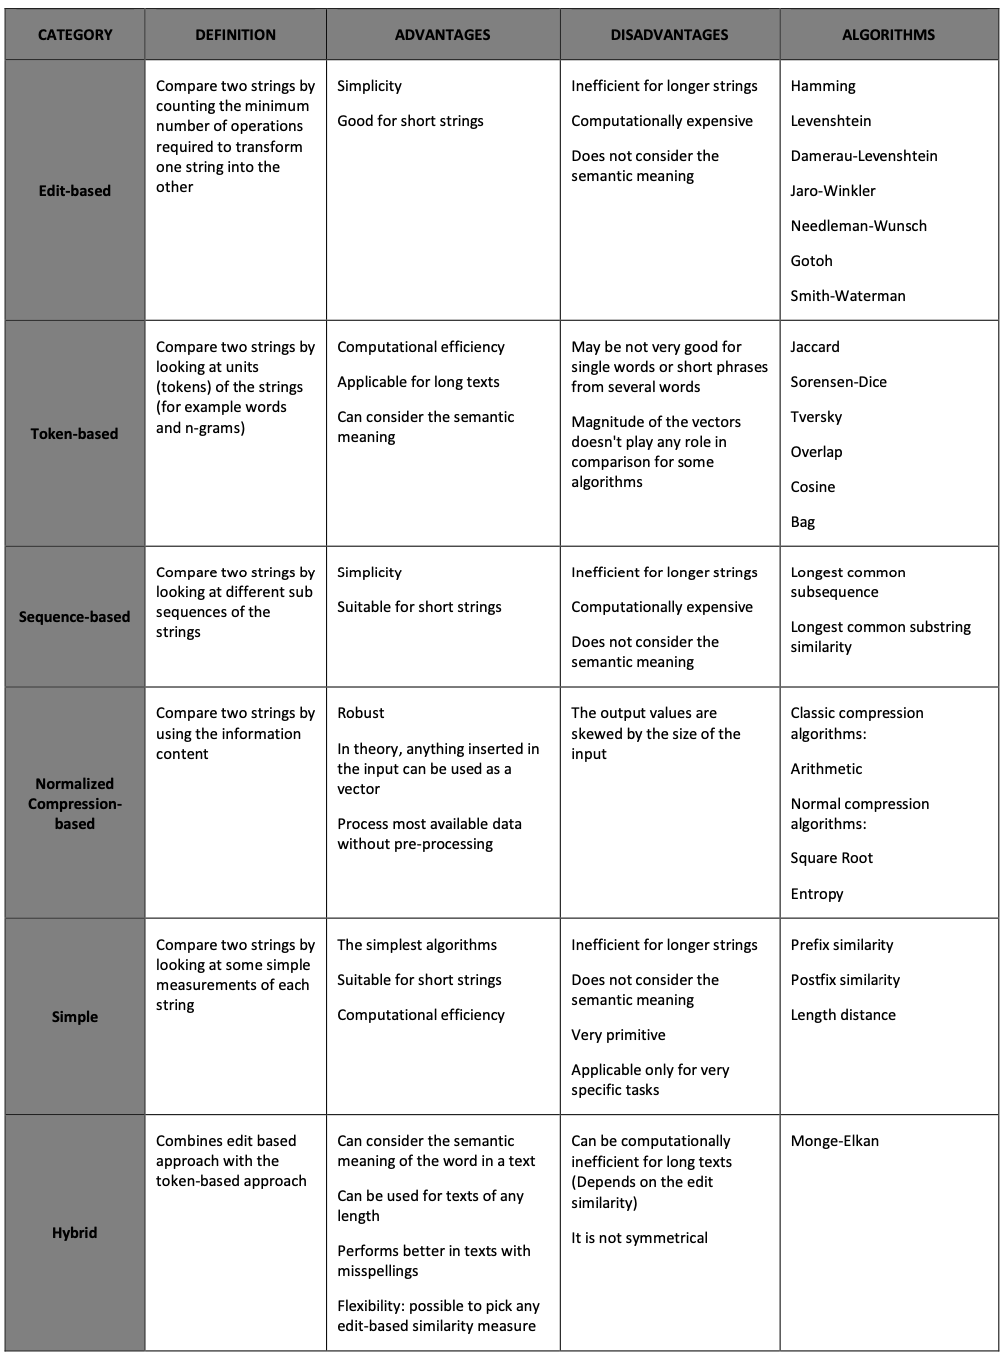


With respect to the algorithms selected, in each group, there are plenty of possible solutions. This way, as demonstrated by the previous table, a significant subset of algorithms is tested in the training datasets in order to consider a large number of possibilities per category.

Thus, the following heatmaps illustrate the maximum correlation achieved by each model in each training dataset and in the merged one (variable "train_data"). It is important to note that, as the final model is a combination of lexical and syntactic dimensions, the following values correspond to this type of configuration.

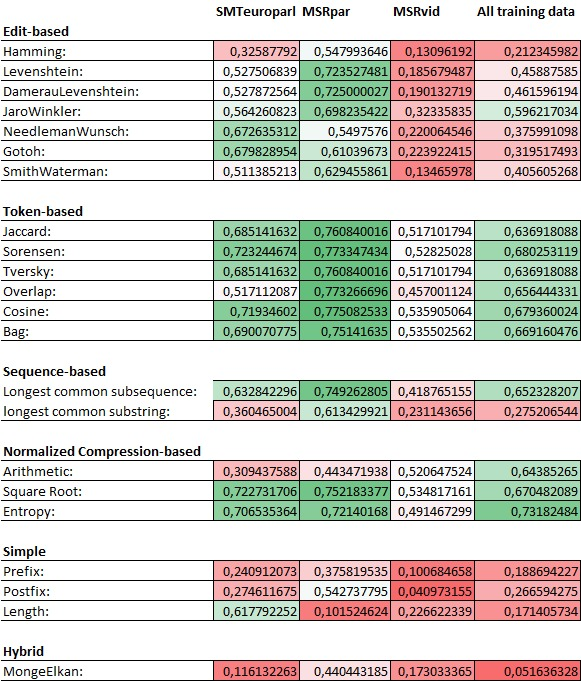

According to the values obtained, it is intended to select the best models to extract the maximum information possible in each category. Thus, the rules for selection are the following:
*   The models are nominated through the heat map representing the merged training data. The remaining are used to comprehend the stability of the model in distinct data files;
*   At least 1 model per category for diversity purposes, independently of the correlation scored in the training dataset;
*   A maximum of 2 models per category. However, the second model is only added if it scores higher than 0.60 in the Pearson correlation.

These rules are based on the fact that diversity is extremely helpful when extracting information. For instance, it's better to add a model from a different category with a low correlation score than a high correlation model from a category that is already represented. Furthermore, the models are limited in the information extration process, so, usually, increase the feature space is more suitable than increment the number of models.
This way, it is intended to find a balance between representation and correlation.

Therefore, the models selected per category are the following:

*   Edit-based: Jaro-Winkler;
*   Token-based: Sørensen–Dice and Cosine;
*   Sequence-based: Longest common subsequence;
*   Compression-based: Square Root and Entropy;
*   Simple: Postfix;
*   Hybrid: None.

It is important to note that the Hybrid category is the only category not represented in this selection. This option depends on the following premises:

1.   As explained before, a Hybrid algorithm relies on a combination of the edit-based and token-based approaches. Since these categories are already represented by algorithms in the proper domain, the addition of this algorithm will only saturate the overall algorithm without producing any significant contribution.
2.   The time complexity of the model is substantial when compared to the selected ones.

Overall, seven distinct models representing six categories were selected. Finally, the library used for the implementation is textdistance 4.5.0 (Library: https://pypi.org/project/textdistance/; Code: https://github.com/life4/textdistance).



**SIMILARITY METRICS EXPLANATION**

After the previous definitions, it is essential to define theoretically how the algorithms work. Furthermore, these definitions are in accordance and referenced by the library mentioned above.

*   **Edit-based: Jaro-Winkler**:

    Jaro–Winkler similarity uses a prefix scale 'p' which gives more favorable ratings to strings that match from the beginning for a set prefix length 'l'. Given two strings 's1' and 's2' their Jaro–Winkler similarity sim_w is:

    sim_w = sim_j + lp(1-sim_j)

    where,

    sim_j is the Jaro similarity for strings s1 and s2

    l is the length of common prefix at the start of the string up to a maximum of 4 characters

    p is a constant scaling factor for how much the score is adjusted upwards for having common prefixes.

    [Text Credits: https://en.wikipedia.org/wiki/Jaro–Winkler_distance ]

*   **Token-based: Sørensen–Dice**:

    In Sørensen's formula, given two sets X and Y, it is defined as:

    DSC = 2|X∩Y| / (|X|+|Y|)

    Where |X| and |Y| are the cardinalities of the two sets (i.e. the number of elements in each set). In other words, the Sørensen index equals twice the number of elements common to both sets divided by the sum of the number of elements in each set.

    [Text Credits: https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient ]

*   **Token-based: Cosine**:

    Given two vectors of attributes, A and B, the cosine similarity, cos(θ), is represented using a dot product and magnitude as

    cos(θ) = A.B / ||A|| ||B||

    [Text Credits: https://en.wikipedia.org/wiki/Cosine_similarity ]

*   **Sequence-based: Longest common subsequence**:

    The longest common subsequence (LCS) problem is the problem of finding the longest subsequence common to all sequences in a set of sequences (often just two sequences). For example, consider the sequences (ABCD) and (ACBAD). They have 5 length-2 common subsequences: (AB), (AC), (AD), (BD), and (CD); 2 length-3 common subsequences: (ABD) and (ACD); and no longer common subsequences. So (ABD) and (ACD) are their longest common subsequences.

    [Text Credits: https://en.wikipedia.org/wiki/Longest_common_subsequence_problem ]

*   **Compression-based: Square Root**:

    Compressed data size equals the sum of square roots of counts of every element in the input sequence.

    [Text Credits: https://github.com/life4/textdistance/blob/master/textdistance/algorithms/compression_based.py ]

*   **Compression-based: Entropy**:

    In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent to the variable's possible outcomes. Given a discrete random variable, X, which takes values in the alphabet *X* and is distributed according to p: *X*->[0,1]:

    H(x) = E(-log_p(X))

    [Text Credits: https://en.wikipedia.org/wiki/Entropy_(information_theory) ]

*   **Simple: Postfix**:

    Calculates the similarity between strings according to the postfixes.

    [Text Credits: https://github.com/life4/textdistance/blob/master/textdistance/algorithms/simple.py ]



In [ ]:
# Edit based
jaro_similarity_data = pd.DataFrame()
# Token based
dice_similarity_data = pd.DataFrame()
cosine_similarity_data = pd.DataFrame()
# Sequence based
lcsseq_similarity_data = pd.DataFrame()
# Compression based
entropy_similarity_data = pd.DataFrame()
sqrtncd_similarity_data = pd.DataFrame()
# Simple
postfix_similarity_data = pd.DataFrame()

for name in feature_list:
  # Edit based
  jaro_similarity_data['jaro_'+name] = ''
  # Token based
  dice_similarity_data['dice_'+name] = ''
  cosine_similarity_data['cosine_'+name] = ''
  # Sequence based
  lcsseq_similarity_data['lcsseq_'+name] = ''
  # Compression based
  entropy_similarity_data['entropy_'+name] = ''
  sqrtncd_similarity_data['sqrtncd_'+name] = ''
  # Simple
  postfix_similarity_data['postfix_'+name] = ''
  

# Edit based
display(jaro_similarity_data)
# Token based
display(dice_similarity_data)
display(cosine_similarity_data)
# Sequence based
display(lcsseq_similarity_data)
# Compression based
display(entropy_similarity_data)
display(sqrtncd_similarity_data)
# Simple
display(postfix_similarity_data)

,jaro_sentence,jaro_token,jaro_stem,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_chunck,jaro_lemma,jaro_synset,jaro_triple,jaro_phoneme_DMetaphone


,dice_sentence,dice_token,dice_stem,dice_2ngram,dice_3ngram,dice_4ngram,dice_phoneme_nysiis,dice_phoneme_soundex,dice_chunck,dice_lemma,dice_synset,dice_triple,dice_phoneme_DMetaphone


,cosine_sentence,cosine_token,cosine_stem,cosine_2ngram,cosine_3ngram,cosine_4ngram,cosine_phoneme_nysiis,cosine_phoneme_soundex,cosine_chunck,cosine_lemma,cosine_synset,cosine_triple,cosine_phoneme_DMetaphone


,lcsseq_sentence,lcsseq_token,lcsseq_stem,lcsseq_2ngram,lcsseq_3ngram,lcsseq_4ngram,lcsseq_phoneme_nysiis,lcsseq_phoneme_soundex,lcsseq_chunck,lcsseq_lemma,lcsseq_synset,lcsseq_triple,lcsseq_phoneme_DMetaphone


,entropy_sentence,entropy_token,entropy_stem,entropy_2ngram,entropy_3ngram,entropy_4ngram,entropy_phoneme_nysiis,entropy_phoneme_soundex,entropy_chunck,entropy_lemma,entropy_synset,entropy_triple,entropy_phoneme_DMetaphone


,sqrtncd_sentence,sqrtncd_token,sqrtncd_stem,sqrtncd_2ngram,sqrtncd_3ngram,sqrtncd_4ngram,sqrtncd_phoneme_nysiis,sqrtncd_phoneme_soundex,sqrtncd_chunck,sqrtncd_lemma,sqrtncd_synset,sqrtncd_triple,sqrtncd_phoneme_DMetaphone


,postfix_sentence,postfix_token,postfix_stem,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple,postfix_phoneme_DMetaphone


In [ ]:
def calculate_distance(sentence1, sentence2):
  # Edit based
  jaro = JaroWinkler().normalized_similarity(sentence1, sentence2)
  # Token based
  dice = Sorensen().normalized_similarity(set(sentence1), set(sentence2))
  cosine = Cosine().normalized_similarity(set(sentence1), set(sentence2))
  # Sequence based
  lcsseq = LCSSeq().normalized_similarity(sentence1, sentence2)
  # Compression based
  entropy = EntropyNCD().normalized_similarity(sentence1, sentence2)
  sqrtncd = SqrtNCD().normalized_similarity(sentence1, sentence2)
  # Simple
  postfix = Postfix().normalized_similarity(sentence1, sentence2)

  return jaro, dice ,cosine, lcsseq, entropy, sqrtncd, postfix

In [ ]:
def get_similarity(data, features1, features2):
  limit = len(data[0][:])
  for id in range(limit):
    for name in feature_list:
      # Get all the similarities
      sim = calculate_distance(features1.loc[id,name], features2.loc[id,name])
      # Edit based
      jaro_similarity_data.at[id, 'jaro_'+name] = sim[0]
      # Token based
      dice_similarity_data.at[id, 'dice_'+name] = sim[1]
      cosine_similarity_data.at[id, 'cosine_'+name] = sim[2]
      # Sequence based
      lcsseq_similarity_data.at[id, 'lcsseq_'+name] = sim[3]
      # Compression based
      entropy_similarity_data.at[id, 'entropy_'+name] = sim[4]
      sqrtncd_similarity_data.at[id, 'sqrtncd_'+name] = sim[5]
      # Simple
      postfix_similarity_data.at[id, 'postfix_'+name] = sim[6]

def display_similarities():
  # Edit based
  display(jaro_similarity_data)
  # Token based
  display(dice_similarity_data)
  display(cosine_similarity_data)
  # Sequence based
  display(lcsseq_similarity_data)
  # Compression based
  display(entropy_similarity_data)
  display(sqrtncd_similarity_data)
  # Simple
  display(postfix_similarity_data)
  
def concatinate_similarities():
  # Get all the similarities
  similarity_data = pd.DataFrame()
  similarity_data = pd.concat([jaro_similarity_data, dice_similarity_data, cosine_similarity_data, lcsseq_similarity_data, entropy_similarity_data, sqrtncd_similarity_data,
                              postfix_similarity_data], axis=1)
  display(similarity_data)
  return similarity_data

In [ ]:
get_similarity(train_data, train_featuresText1, train_featuresText2)

In [ ]:
display_similarities()

,jaro_sentence,jaro_token,jaro_stem,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_chunck,jaro_lemma,jaro_synset,jaro_triple,jaro_phoneme_DMetaphone
0,0.657934,0.539683,0.527778,0.527778,0.405303,0.0,0.483333,0.539683,0.0,0.527778,0.527778,0.835088,0.60119
1,0.877035,0.672767,0.708333,0.686368,0.456439,0.496667,0.672767,0.672767,0.587302,0.708333,0.648148,0.623638,0.659512
2,0.858148,0.666667,0.555556,0.653846,0.583333,0.555556,0.5,0.666667,0.666667,0.555556,0.555556,0.91,0.619048
3,0.89677,0.822222,0.555556,0.613054,0.671958,0.577778,0.527778,0.822222,0.666667,0.555556,0.555556,0.915441,0.805556
4,0.830291,0.629966,0.672222,0.476706,0.459035,0.486111,0.640491,0.629966,0.425926,0.672222,0.425926,0.674066,0.640738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.755676,0.764103,0.804714,0.294053,0.35578,0.0,0.827839,0.764103,0.783333,0.804714,0.805556,0.746198,0.824405
2230,0.860409,0.637255,0.558333,0.500382,0.615546,0.419414,0.637255,0.637255,0.587302,0.558333,0.60119,0.852804,0.638095
2231,0.937143,0.933333,0.941667,0.929412,0.927273,0.925,0.906667,0.933333,0.911111,0.941667,0.941667,0.945455,0.933333
2232,0.705678,0.60119,0.472222,0.222989,0.376518,0.0,0.619048,0.60119,0.511111,0.472222,0.0,0.634275,0.555556


,dice_sentence,dice_token,dice_stem,dice_2ngram,dice_3ngram,dice_4ngram,dice_phoneme_nysiis,dice_phoneme_soundex,dice_chunck,dice_lemma,dice_synset,dice_triple,dice_phoneme_DMetaphone
0,0.774194,0.307692,0.285714,0.285714,0.105263,0.0,0.222222,0.307692,0.4,0.285714,0.285714,0.62069,0.428571
1,0.954545,0.580645,0.588235,0.627907,0.190476,0.244898,0.580645,0.580645,0.4,0.588235,0.5,0.721311,0.564103
2,0.8,0.5,0.333333,0.5,0.375,0.333333,0.25,0.5,0.5,0.333333,0.333333,0.814815,0.428571
3,0.827586,0.615385,0.333333,0.454545,0.5,0.363636,0.285714,0.615385,0.5,0.333333,0.333333,0.740741,0.5
4,0.893617,0.666667,0.666667,0.43038,0.344828,0.227273,0.592593,0.645161,0.533333,0.666667,0.533333,0.774194,0.647059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.826087,0.642857,0.7,0.246914,0.033333,0.044444,0.740741,0.642857,0.666667,0.7,0.705882,0.701754,0.733333
2230,0.938776,0.451613,0.333333,0.380952,0.42623,0.12766,0.451613,0.466667,0.375,0.333333,0.4,0.655738,0.457143
2231,0.875,0.857143,0.857143,0.785714,0.777778,0.769231,0.75,0.857143,0.8,0.857143,0.857143,0.896552,0.833333
2232,0.810811,0.4,0.6,0.130435,0.375,0.0,0.428571,0.4,0.5,0.6,0.2,0.648649,0.333333


,cosine_sentence,cosine_token,cosine_stem,cosine_2ngram,cosine_3ngram,cosine_4ngram,cosine_phoneme_nysiis,cosine_phoneme_soundex,cosine_chunck,cosine_lemma,cosine_synset,cosine_triple,cosine_phoneme_DMetaphone
0,0.777844,0.308607,0.288675,0.288675,0.1066,0.0,0.223607,0.308607,0.408248,0.288675,0.288675,0.624038,0.428571
1,0.955533,0.580948,0.589256,0.628077,0.1905,0.244949,0.580948,0.580948,0.400892,0.589256,0.5,0.721408,0.568796
2,0.801784,0.5,0.333333,0.5,0.375,0.333333,0.25,0.5,0.5,0.333333,0.333333,0.815374,0.428571
3,0.83205,0.617213,0.333333,0.46225,0.503953,0.365148,0.288675,0.617213,0.5,0.333333,0.333333,0.741249,0.507093
4,0.893819,0.669439,0.67082,0.431244,0.346688,0.228218,0.596285,0.648204,0.544331,0.67082,0.544331,0.777844,0.651584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.829228,0.644503,0.703526,0.248452,0.033501,0.044721,0.741249,0.644503,0.67082,0.703526,0.707107,0.707107,0.734968
2230,0.94054,0.453743,0.33541,0.381385,0.429064,0.128388,0.453743,0.467707,0.377964,0.33541,0.400892,0.660098,0.46188
2231,0.881917,0.866025,0.866025,0.8044,0.797724,0.790569,0.774597,0.866025,0.816497,0.866025,0.866025,0.901388,0.845154
2232,0.813489,0.400892,0.612372,0.131559,0.381771,0.0,0.428571,0.400892,0.516398,0.612372,0.204124,0.650791,0.333333


,lcsseq_sentence,lcsseq_token,lcsseq_stem,lcsseq_2ngram,lcsseq_3ngram,lcsseq_4ngram,lcsseq_phoneme_nysiis,lcsseq_phoneme_soundex,lcsseq_chunck,lcsseq_lemma,lcsseq_synset,lcsseq_triple,lcsseq_phoneme_DMetaphone
0,0.441176,0.857143,1.25,0.5,0.272727,0.0,1.0,0.428571,1.666667,1.25,3.5,2.105263,0.875
1,0.663366,2.235294,2.8,1.08,0.545455,0.96,1.647059,1.235294,2.0,3.1,5.111111,2.214286,1.125
2,0.703704,1.0,1.0,0.923077,1.125,1.333333,0.75,0.833333,1.5,1.0,2.666667,2.4375,0.714286
3,0.642857,1.0,1.0,0.769231,1.333333,1.333333,0.75,0.857143,1.5,1.0,3.0,2.352941,0.75
4,0.53,1.666667,2.9,0.571429,0.909091,0.833333,1.3125,0.944444,1.888889,3.0,3.666667,2.173913,0.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.666667,3.2,3.181818,0.16,0.090909,0.16,3.285714,1.866667,4.3,3.909091,9.444444,2.674419,2.25
2230,0.561905,2.0,2.0,0.5,1.147059,0.461538,1.647059,1.235294,2.666667,2.2,4.5,2.372093,1.238095
2231,0.685714,2.0,2.75,1.294118,1.909091,2.5,2.6,1.444444,3.0,2.75,8.25,2.5,1.444444
2232,0.466667,2.5,2.833333,0.137931,0.947368,0.0,2.428571,1.375,2.2,3.333333,1.666667,2.173913,1.222222


,entropy_sentence,entropy_token,entropy_stem,entropy_2ngram,entropy_3ngram,entropy_4ngram,entropy_phoneme_nysiis,entropy_phoneme_soundex,entropy_chunck,entropy_lemma,entropy_synset,entropy_triple,entropy_phoneme_DMetaphone
0,0.926178,0.787836,0.687774,0.812664,0.743765,0.694402,0.714713,0.787836,0.64335,0.687774,0.687774,0.903549,0.849441
1,0.984971,0.90581,0.888081,0.93977,0.857828,0.860937,0.90581,0.90581,0.824545,0.888081,0.862119,0.945931,0.880246
2,0.947898,0.860529,0.742098,0.889406,0.84375,0.814038,0.75,0.860529,0.75,0.742098,0.742098,0.947998,0.849915
3,0.946004,0.868651,0.742098,0.820671,0.833895,0.784135,0.687774,0.868651,0.75,0.742098,0.742098,0.94342,0.813711
4,0.970953,0.908928,0.883557,0.900584,0.867518,0.837021,0.886612,0.904531,0.810885,0.883557,0.810885,0.941883,0.903684
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.962532,0.905427,0.898641,0.85997,0.814924,0.800583,0.934744,0.905427,0.883557,0.898641,0.908492,0.92271,0.92676
2230,0.987895,0.863345,0.806431,0.898619,0.87606,0.818503,0.863345,0.877991,0.803919,0.806431,0.825116,0.917671,0.85991
2231,0.958832,0.914312,0.87825,0.889491,0.868864,0.84768,0.799804,0.914312,0.798091,0.87825,0.87825,0.962573,0.904451
2232,0.948376,0.825116,0.798623,0.823706,0.823824,0.73727,0.849915,0.825116,0.724546,0.798623,0.687046,0.914291,0.840125


,sqrtncd_sentence,sqrtncd_token,sqrtncd_stem,sqrtncd_2ngram,sqrtncd_3ngram,sqrtncd_4ngram,sqrtncd_phoneme_nysiis,sqrtncd_phoneme_soundex,sqrtncd_chunck,sqrtncd_lemma,sqrtncd_synset,sqrtncd_triple,sqrtncd_phoneme_DMetaphone
0,0.400296,0.167368,0.146447,0.146447,0.053253,0.0,0.117157,0.167368,0.195262,0.146447,0.146447,0.347975,0.250025
1,0.554341,0.32119,0.321355,0.372735,0.109835,0.140589,0.32119,0.32119,0.208856,0.321355,0.278475,0.419641,0.286486
2,0.461649,0.292893,0.195262,0.290884,0.21967,0.195262,0.146447,0.292893,0.292893,0.195262,0.195262,0.47724,0.251051
3,0.451993,0.334735,0.195262,0.24013,0.26035,0.195262,0.146447,0.334735,0.292893,0.195262,0.195262,0.432063,0.269752
4,0.507135,0.357981,0.351472,0.241187,0.188205,0.122039,0.319765,0.350318,0.26035,0.351472,0.26035,0.412143,0.349444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.478564,0.351472,0.372773,0.136804,0.017751,0.023431,0.418419,0.351472,0.351472,0.372773,0.390524,0.385064,0.402728
2230,0.519839,0.241206,0.175736,0.212353,0.226812,0.067591,0.241206,0.255686,0.195262,0.175736,0.21967,0.353752,0.234281
2231,0.457211,0.429166,0.43934,0.379038,0.372773,0.366117,0.351472,0.429166,0.390524,0.43934,0.43934,0.471993,0.420761
2232,0.437148,0.21967,0.292893,0.073675,0.184985,0.0,0.251051,0.21967,0.234315,0.292893,0.097631,0.346871,0.195262


,postfix_sentence,postfix_token,postfix_stem,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple,postfix_phoneme_DMetaphone
0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0
1,0.257426,0.176471,0.3,0.24,0.0,0.0,0.176471,0.176471,0.222222,0.3,0.333333,0.309524,0.166667
2,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1875,0.0
3,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0
4,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.058824,0.066667,0.090909,0.0,0.0,0.0,0.071429,0.066667,0.0,0.090909,0.111111,0.116279,0.0625
2230,0.019048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0
2231,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0
2232,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0


In [ ]:
similarity_data = concatinate_similarities()

,jaro_sentence,jaro_token,jaro_stem,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_chunck,jaro_lemma,...,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple,postfix_phoneme_DMetaphone
0,0.657934,0.539683,0.527778,0.527778,0.405303,0.0,0.483333,0.539683,0.0,0.527778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0
1,0.877035,0.672767,0.708333,0.686368,0.456439,0.496667,0.672767,0.672767,0.587302,0.708333,...,0.24,0.0,0.0,0.176471,0.176471,0.222222,0.3,0.333333,0.309524,0.166667
2,0.858148,0.666667,0.555556,0.653846,0.583333,0.555556,0.5,0.666667,0.666667,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1875,0.0
3,0.89677,0.822222,0.555556,0.613054,0.671958,0.577778,0.527778,0.822222,0.666667,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0
4,0.830291,0.629966,0.672222,0.476706,0.459035,0.486111,0.640491,0.629966,0.425926,0.672222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.755676,0.764103,0.804714,0.294053,0.35578,0.0,0.827839,0.764103,0.783333,0.804714,...,0.0,0.0,0.0,0.071429,0.066667,0.0,0.090909,0.111111,0.116279,0.0625
2230,0.860409,0.637255,0.558333,0.500382,0.615546,0.419414,0.637255,0.637255,0.587302,0.558333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0
2231,0.937143,0.933333,0.941667,0.929412,0.927273,0.925,0.906667,0.933333,0.911111,0.941667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0
2232,0.705678,0.60119,0.472222,0.222989,0.376518,0.0,0.619048,0.60119,0.511111,0.472222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0


# Final Model: Train, Validation and Test

**SUPERVISED LEARNINGN MODEL SELECTION**

In this section of the project, it is essential to define a model able to combine the similarities determined by the previous models (Jaro-Winkler, Sørensen–Dice, Cosine, Longest common subsequence, Square Root, Entropy, and Postfix). This way, as the inputs (similarity given by the previous models) and the outputs (gold standard), are available, it is considered to perform supervised learning. Thus, three algorithms are used:

*   **Random Forest Regressor** (library: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
*   **XGBoost Regression** (library: https://xgboost.readthedocs.io/en/stable/tutorials/rf.html)
*   **MLP Regressor** (library: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)


This process is divided into four main phases:
*   **Feature Importance Selection**: In this part, the Random Forest Regressor from Sklearn is applied to all the training data, in order to obtain the features' importance. For values equal to 0.00 (which means no importance), the feature is deleted from the data frame. This approach leads to better correlation results through feature dimensionality reduction.
*   **Training**: All the models mentioned are trained on 90% of the resulting dataset from the previous process.
*   **Validation**: All the models mentioned are validated in 10% of the resulting dataset of the first process. Through these Pearson correlation values, the best model is chosen.
*   **Testing**: The selected model in the previous stage is tested in the testing data.

# Training and Validation Data

In [ ]:
similarity_data

,jaro_sentence,jaro_token,jaro_stem,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_chunck,jaro_lemma,...,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple,postfix_phoneme_DMetaphone
0,0.657934,0.539683,0.527778,0.527778,0.405303,0.0,0.483333,0.539683,0.0,0.527778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0
1,0.877035,0.672767,0.708333,0.686368,0.456439,0.496667,0.672767,0.672767,0.587302,0.708333,...,0.24,0.0,0.0,0.176471,0.176471,0.222222,0.3,0.333333,0.309524,0.166667
2,0.858148,0.666667,0.555556,0.653846,0.583333,0.555556,0.5,0.666667,0.666667,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1875,0.0
3,0.89677,0.822222,0.555556,0.613054,0.671958,0.577778,0.527778,0.822222,0.666667,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0
4,0.830291,0.629966,0.672222,0.476706,0.459035,0.486111,0.640491,0.629966,0.425926,0.672222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.755676,0.764103,0.804714,0.294053,0.35578,0.0,0.827839,0.764103,0.783333,0.804714,...,0.0,0.0,0.0,0.071429,0.066667,0.0,0.090909,0.111111,0.116279,0.0625
2230,0.860409,0.637255,0.558333,0.500382,0.615546,0.419414,0.637255,0.637255,0.587302,0.558333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0
2231,0.937143,0.933333,0.941667,0.929412,0.927273,0.925,0.906667,0.933333,0.911111,0.941667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0
2232,0.705678,0.60119,0.472222,0.222989,0.376518,0.0,0.619048,0.60119,0.511111,0.472222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0


# Feature selection

From the combination of all the models with all the considered features (lexical and syntatic), there is a total of 91 combinations. From that, the Random Forest Regressor indicates, as shown in the output, that only 27 out of 91 (30%) are important to the final prediction.

According to the values obtained all the 7 models (Jaro-Winkler, Sørensen–Dice, Cosine, Longest common subsequence, Square Root, Entropy, and Postfix) are considered with some degree of importance. The number of times each model is considered and the total importance associated are:

*   **Jaro-Winkler**: 3 (23% - 3 in 13) - Total importance: 0.03
*   **Sørensen–Dice**: 3 (23% - 3 in 13) - Total importance: 0.03
*   **Cosine**: 3 (23% - 3 in 13) - Total importance: 0.04
*   **Longest common subsequence**: 7 (54% - 3 in 13) - Total importance: 0.09
*   **Square Root**: 3 (23% - 3 in 13) - Total importance: 0.08
*   **Entropy**: 6 (46% - 3 in 13) - Total importance: 0.57
*   **Postfix**: 2 (15% - 3 in 13) - Total importance: 0.02

**27 Times Total** 

**0.86 Total Importance** 

According to the values obtained the two most represented methods are Longest common subsequence and Entropy, corresponding to Sequence-based and Compression-based, respectively. Aditionally, these are also the most important models. For instance, it is interesting that the most important combination (Entropy and Stem) have 0.51 of importance, while the second most important (Square Root and sentence) has 0.06 of importance, a discrepancy of 0.45.

Furthermore, the fact that all the models contain a certain degree of importance indicates the relevance on the variety in the categories, independently of the correlation scored.

In the features prespective, only 9 of the 13 (69%) have a non-null importance. Specifically, 3 (33%) belong to the syntatic dimension, while the ramaining 6 (66%) correspond to the lexical field. According to that, 75% (3 in 4) of the syntatic features remain important, while in the lexical part the value is 67% (6 in 9).

Furthermore, the number of times each feature is considered important along with the total importance is:

**Lexical Features (17 times total - 0.75 Total Importance)**:
*   **sentence**: 7 (54% - 7 in 13) - Total importance: 0.14
*   **token**: 0 (0% - 0 in 13) - Total importance: 0.00
*   **stem**: 5 (38% - 5 in 13) - Total importance: 0.56
*   **n-grams**: 2 (15% - 2 in 13) - Total importance: 0.02
*   **phoneme**: 3 (23% - 3 in 13) - Total importance: 0.03

**Syntatic Features (10 times total - 0.11 Total Importance)**:
*   **synset**: 0 (0% - 0 in 13) - Total importance: 0.00
*   **chunck**: 1 (8% - 1 in 13) - Total importance: 0.01
*   **lemma**: 4 (31% - 4 in 13) - Total importance: 0.05
*   **triple**: 5 (38% - 5 in 13) - Total importance: 0.05

**27 Times Total** 

**0.86 Total Importance** 

Thus, the most frequent features, for the selected models, are sentences, stem and triples. Furthermore, by a considerable margin, sentences and stems are the most relevant features in the project developed. On the other hand, tokens and synsets do not have any importance, indicating that, among the other features, these are non-relevant represenations of the sentences.

Finally, overall, the Lexical features have the most relevant importance by a notable difference of 0.64. This discrepancy is shown in the testing results were the correlation with only lexical features is considerably better than with syntatic ones. However, the best approach is in fact a combination between both.

By comparing only lexical or syntactic features, it is understandable that the results are approximately the same since the models and features most relevant remain.

However, some important topics to mention are:
*   From the lexical to the syntactic, the stem ranking positions and values of importance are achieved by the lemmas. This indicates that stems and lemmas might be redundant in terms of information, for the models utilized. 
*   By considering the lexical or syntactic features alone, all the features have some degree of importance.

In [ ]:
# Get the colums sets for each category of features. This is used to filter by feature category.
lexical_col = []
syntactic_col = []
for col in similarity_data.columns:
  if "sentence" in col or "token" in col or "stem" in col or "ngram" in col or "phoneme" in col:
    lexical_col.append(col)
  else:
    syntactic_col.append(col)

similarity_columns = [similarity_data.columns, lexical_col, syntactic_col]

In [ ]:
# Define and train random forest
important_columns = [[],[],[]]
rf = RandomForestRegressor(n_estimators=4000, max_depth=None, n_jobs=-1)
for i, name in zip([0, 1, 2], ["Both", "Lexical", "Syntactic"]):
  rf_model = rf.fit(similarity_data[similarity_columns[i]], train_data.loc[:, 'gs'])

  # Get numerical feature importances
  importances = list(rf_model.feature_importances_)
  # List of tuples with variable and importance
  feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(similarity_columns[i], importances)]
  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
  # Print out the feature and importances 
  print("\nImportance for", name, ":")
  for pair in feature_importances:
    print('Feature: {:30} Importance: {}'.format(*pair))
  # Deleting features with 0.0 importance
  for pair in feature_importances:
    if pair[1] > 0.0: important_columns[i].append(pair[0])


Importance for Both :
Feature: entropy_stem                   Importance: 0.51
Feature: sqrtncd_sentence               Importance: 0.06
Feature: cosine_sentence                Importance: 0.02
Feature: lcsseq_stem                    Importance: 0.02
Feature: lcsseq_lemma                   Importance: 0.02
Feature: entropy_sentence               Importance: 0.02
Feature: jaro_sentence                  Importance: 0.01
Feature: jaro_2ngram                    Importance: 0.01
Feature: jaro_triple                    Importance: 0.01
Feature: dice_sentence                  Importance: 0.01
Feature: dice_stem                      Importance: 0.01
Feature: dice_lemma                     Importance: 0.01
Feature: cosine_stem                    Importance: 0.01
Feature: cosine_lemma                   Importance: 0.01
Feature: lcsseq_sentence                Importance: 0.01
Feature: lcsseq_phoneme_nysiis          Importance: 0.01
Feature: lcsseq_phoneme_soundex         Importance: 0.01
Feature:

,jaro_sentence,jaro_token,jaro_stem,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_chunck,jaro_lemma,...,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple,postfix_phoneme_DMetaphone
0,0.657934,0.539683,0.527778,0.527778,0.405303,0.0,0.483333,0.539683,0.0,0.527778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0
1,0.877035,0.672767,0.708333,0.686368,0.456439,0.496667,0.672767,0.672767,0.587302,0.708333,...,0.24,0.0,0.0,0.176471,0.176471,0.222222,0.3,0.333333,0.309524,0.166667
2,0.858148,0.666667,0.555556,0.653846,0.583333,0.555556,0.5,0.666667,0.666667,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1875,0.0
3,0.89677,0.822222,0.555556,0.613054,0.671958,0.577778,0.527778,0.822222,0.666667,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0
4,0.830291,0.629966,0.672222,0.476706,0.459035,0.486111,0.640491,0.629966,0.425926,0.672222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.755676,0.764103,0.804714,0.294053,0.35578,0.0,0.827839,0.764103,0.783333,0.804714,...,0.0,0.0,0.0,0.071429,0.066667,0.0,0.090909,0.111111,0.116279,0.0625
2230,0.860409,0.637255,0.558333,0.500382,0.615546,0.419414,0.637255,0.637255,0.587302,0.558333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0
2231,0.937143,0.933333,0.941667,0.929412,0.927273,0.925,0.906667,0.933333,0.911111,0.941667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0
2232,0.705678,0.60119,0.472222,0.222989,0.376518,0.0,0.619048,0.60119,0.511111,0.472222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0



Importance for Lexical :
Feature: entropy_stem                   Importance: 0.52
Feature: sqrtncd_sentence               Importance: 0.06
Feature: lcsseq_stem                    Importance: 0.04
Feature: cosine_stem                    Importance: 0.03
Feature: jaro_sentence                  Importance: 0.02
Feature: cosine_sentence                Importance: 0.02
Feature: entropy_sentence               Importance: 0.02
Feature: jaro_stem                      Importance: 0.01
Feature: jaro_2ngram                    Importance: 0.01
Feature: jaro_3ngram                    Importance: 0.01
Feature: jaro_4ngram                    Importance: 0.01
Feature: jaro_phoneme_nysiis            Importance: 0.01
Feature: jaro_phoneme_DMetaphone        Importance: 0.01
Feature: dice_sentence                  Importance: 0.01
Feature: dice_stem                      Importance: 0.01
Feature: lcsseq_sentence                Importance: 0.01
Feature: lcsseq_token                   Importance: 0.01
Featu

,jaro_sentence,jaro_token,jaro_stem,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_phoneme_DMetaphone,dice_sentence,dice_token,dice_stem,dice_phoneme_nysiis,...,sqrtncd_stem,sqrtncd_phoneme_nysiis,sqrtncd_phoneme_soundex,sqrtncd_phoneme_DMetaphone,postfix_sentence,postfix_token,postfix_stem,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_phoneme_DMetaphone
0,0.657934,0.539683,0.527778,0.483333,0.539683,0.60119,0.774194,0.307692,0.285714,0.222222,...,0.146447,0.117157,0.167368,0.250025,0.029412,0.0,0.0,0.0,0.0,0.0
1,0.877035,0.672767,0.708333,0.672767,0.672767,0.659512,0.954545,0.580645,0.588235,0.580645,...,0.321355,0.32119,0.32119,0.286486,0.257426,0.176471,0.3,0.176471,0.176471,0.166667
2,0.858148,0.666667,0.555556,0.5,0.666667,0.619048,0.8,0.5,0.333333,0.25,...,0.195262,0.146447,0.292893,0.251051,0.037037,0.0,0.0,0.0,0.0,0.0
3,0.89677,0.822222,0.555556,0.527778,0.822222,0.805556,0.827586,0.615385,0.333333,0.285714,...,0.195262,0.146447,0.334735,0.269752,0.035714,0.0,0.0,0.0,0.0,0.0
4,0.830291,0.629966,0.672222,0.640491,0.629966,0.640738,0.893617,0.666667,0.666667,0.592593,...,0.351472,0.319765,0.350318,0.349444,0.01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.755676,0.764103,0.804714,0.827839,0.764103,0.824405,0.826087,0.642857,0.7,0.740741,...,0.372773,0.418419,0.351472,0.402728,0.058824,0.066667,0.090909,0.071429,0.066667,0.0625
2230,0.860409,0.637255,0.558333,0.637255,0.637255,0.638095,0.938776,0.451613,0.333333,0.451613,...,0.175736,0.241206,0.255686,0.234281,0.019048,0.0,0.0,0.0,0.0,0.0
2231,0.937143,0.933333,0.941667,0.906667,0.933333,0.933333,0.875,0.857143,0.857143,0.75,...,0.43934,0.351472,0.429166,0.420761,0.028571,0.0,0.0,0.0,0.0,0.0
2232,0.705678,0.60119,0.472222,0.619048,0.60119,0.555556,0.810811,0.4,0.6,0.428571,...,0.292893,0.251051,0.21967,0.195262,0.016667,0.0,0.0,0.0,0.0,0.0



Importance for Syntactic :
Feature: entropy_lemma                  Importance: 0.54
Feature: lcsseq_lemma                   Importance: 0.07
Feature: postfix_triple                 Importance: 0.04
Feature: jaro_triple                    Importance: 0.03
Feature: cosine_lemma                   Importance: 0.03
Feature: lcsseq_triple                  Importance: 0.03
Feature: sqrtncd_triple                 Importance: 0.03
Feature: lcsseq_chunck                  Importance: 0.02
Feature: lcsseq_synset                  Importance: 0.02
Feature: entropy_chunck                 Importance: 0.02
Feature: entropy_triple                 Importance: 0.02
Feature: jaro_chunck                    Importance: 0.01
Feature: jaro_lemma                     Importance: 0.01
Feature: jaro_synset                    Importance: 0.01
Feature: dice_lemma                     Importance: 0.01
Feature: dice_triple                    Importance: 0.01
Feature: cosine_chunck                  Importance: 0.01
Fea

,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_chunck,jaro_lemma,jaro_synset,jaro_triple,dice_2ngram,dice_3ngram,dice_4ngram,...,sqrtncd_lemma,sqrtncd_synset,sqrtncd_triple,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple
0,0.527778,0.405303,0.0,0.0,0.527778,0.527778,0.835088,0.285714,0.105263,0.0,...,0.146447,0.146447,0.347975,0.0,0.0,0.0,0.0,0.0,0.0,0.157895
1,0.686368,0.456439,0.496667,0.587302,0.708333,0.648148,0.623638,0.627907,0.190476,0.244898,...,0.321355,0.278475,0.419641,0.24,0.0,0.0,0.222222,0.3,0.333333,0.309524
2,0.653846,0.583333,0.555556,0.666667,0.555556,0.555556,0.91,0.5,0.375,0.333333,...,0.195262,0.195262,0.47724,0.0,0.0,0.0,0.0,0.0,0.0,0.1875
3,0.613054,0.671958,0.577778,0.666667,0.555556,0.555556,0.915441,0.454545,0.5,0.363636,...,0.195262,0.195262,0.432063,0.0,0.0,0.0,0.0,0.0,0.0,0.058824
4,0.476706,0.459035,0.486111,0.425926,0.672222,0.425926,0.674066,0.43038,0.344828,0.227273,...,0.351472,0.26035,0.412143,0.0,0.0,0.0,0.0,0.0,0.0,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.294053,0.35578,0.0,0.783333,0.804714,0.805556,0.746198,0.246914,0.033333,0.044444,...,0.372773,0.390524,0.385064,0.0,0.0,0.0,0.0,0.090909,0.111111,0.116279
2230,0.500382,0.615546,0.419414,0.587302,0.558333,0.60119,0.852804,0.380952,0.42623,0.12766,...,0.175736,0.21967,0.353752,0.0,0.0,0.0,0.0,0.0,0.0,0.023256
2231,0.929412,0.927273,0.925,0.911111,0.941667,0.941667,0.945455,0.785714,0.777778,0.769231,...,0.43934,0.43934,0.471993,0.0,0.0,0.0,0.0,0.0,0.0,0.045455
2232,0.222989,0.376518,0.0,0.511111,0.472222,0.0,0.634275,0.130435,0.375,0.0,...,0.292893,0.097631,0.346871,0.0,0.0,0.0,0.0,0.0,0.0,0.043478


# Train

In [ ]:
# Spliting the data
train_split = 0.9

boundry = round(len(similarity_data)*0.9)
similarity_data_train = similarity_data.loc[:boundry]
similarity_data_validation = similarity_data.loc[boundry:]
gs_train = train_data.loc[:boundry, 'gs']
gs_validation = train_data.loc[boundry:, 'gs']

## Random Forest

In [ ]:
# Define and train random forest
rf_both = RandomForestRegressor(n_estimators=4000, max_depth=None, n_jobs=-1)
rf_lexical = RandomForestRegressor(n_estimators=4000, max_depth=None, n_jobs=-1)
rf_syntactic = RandomForestRegressor(n_estimators=4000, max_depth=None, n_jobs=-1)

rf_model_both = rf_both.fit(similarity_data_train[important_columns[0]], gs_train)
rf_model_lexical = rf_lexical.fit(similarity_data_train[important_columns[1]], gs_train)
rf_model_syntactic = rf_syntactic.fit(similarity_data_train[important_columns[2]], gs_train)

## MLPRegressor

In [ ]:
pearson_scorer = make_scorer(lambda y, y_hat: pearsonr(y, y_hat)[0])

param_grid = {
    'hidden_layer_sizes': [(300, 200, 100)],
    'max_iter': [7000],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'momentum': [0.7],
    'learning_rate': ['adaptive'],
}
mlp_reg = MLPRegressor()
grid = GridSearchCV(mlp_reg, param_grid, scoring=pearson_scorer, n_jobs= -1, cv=10)
regr = grid.fit(similarity_data_train, gs_train)

"\n\n# Define and train MLP\nregr = MLPRegressor(random_state=1,  learning_rate_init=0.0001, activation='tanh', hidden_layer_sizes=(300, 200, 100), learning_rate='adaptive', max_iter=7000).fit(similarity_data.loc[:], train_data.loc[:, 'gs'])\n"

## XGBoost

In [ ]:
xg = xgboost.XGBRegressor(n_estimators=4000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xg_model = xg.fit(np.array(similarity_data_train), gs_train)

[01:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Validation

As mentioned previously, the validation set (10% of the training data) indicates which is the best model to select and use in the test data. So, taking into account the values obtained, the most suitable model is the Random Forest Regressor with roughly 86%, when all the features are used. If only lexical or syntactic features are used the correlation decreses to 85% in both cases.

It is not expected that the value in the test data is close to the validation one. Firstly, the test data has two extra datasets without any training correspondence, which creates an increased domain shift, where the capacity for the model to generalize decreases. Furthermore, the models considered to get the similarities are not flexible enough to perform well in all datasets. This variation in the correlation is visible in the heat maps.

## Random Forest

In [ ]:
# Predict with validation data both feature group
y_pred = rf_model_both.predict(similarity_data_validation[important_columns[0]])
corr, p = pearsonr(gs_validation, y_pred)
print('Validation correlation both feature groups:', corr)

# Predict with validation data 
y_pred = rf_model_lexical.predict(similarity_data_validation[important_columns[1]])
corr, p = pearsonr(gs_validation, y_pred)
print('Validation correlation lexical features:', corr)

# Predict with validation data
y_pred = rf_model_syntactic.predict(similarity_data_validation[important_columns[2]])
corr, p = pearsonr(gs_validation, y_pred)
print('Validation correlation syntactic features:', corr)

Validation correlation both feature groups: 0.8596823372979938
Validation correlation lexical features: 0.850827446765727
Validation correlation syntactic features: 0.8522070848014909


## MLPRegressor

In [ ]:
# Predict with validation data
# Predict
y_pred = regr.predict(similarity_data_validation)
corr, p = pearsonr(gs_validation, y_pred)
print('Validation correlation:', corr)

Validation correlation: 0.8471399600396482


## XGBoost

In [ ]:
# Predict with validation data
y_pred = xg_model.predict(np.array(similarity_data_validation))
corr, p = pearsonr(gs_validation, y_pred)
print('Validation correlation:', corr)

Validation correlation: 0.8521464895647234


# Test

In [ ]:
# Clean the similarity dataframe
# Edit based
jaro_similarity_data.drop(jaro_similarity_data.index,inplace=True)
# Token based
dice_similarity_data.drop(dice_similarity_data.index,inplace=True) 
cosine_similarity_data.drop(cosine_similarity_data.index,inplace=True) 
# Sequence based
lcsseq_similarity_data.drop(lcsseq_similarity_data.index,inplace=True) 
# Compression based
entropy_similarity_data.drop(entropy_similarity_data.index,inplace=True) 
sqrtncd_similarity_data.drop(sqrtncd_similarity_data.index,inplace=True) 
# Simple
postfix_similarity_data.drop(postfix_similarity_data.index,inplace=True) 

In [ ]:
# Get the similarities between test sentences
get_similarity(test_data, test_featuresText1, test_featuresText2)

In [ ]:
display_similarities()

,jaro_sentence,jaro_token,jaro_stem,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_chunck,jaro_lemma,jaro_synset,jaro_triple,jaro_phoneme_DMetaphone
0,0.852743,0.656863,0.633333,0.62021,0.462302,0.539683,0.655556,0.615196,0.633333,0.633333,0.690476,0.846861,0.610245
1,0.919276,0.939899,1.0,0.918904,0.528116,0.906972,0.946667,0.939899,0.911111,1.0,1.0,0.952222,0.936752
2,0.733388,0.705128,0.666667,0.478063,0.653846,0.0,0.716239,0.705128,0.555556,0.619048,0.7,0.652384,0.688889
3,0.952257,0.902273,0.853333,0.952381,0.924675,0.87,0.904762,0.902273,0.9,0.853333,0.9,0.952381,0.923232
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.902326,0.914286,0.906667,0.895238,0.9,0.9,0.914286,0.914286,0.866667,0.906667,0.906667,0.905263,0.911111
3104,0.712406,0.820833,0.866667,0.579939,0.479689,0.678054,0.88,0.820833,0.708333,0.644444,0.644444,0.786325,0.896296
3105,0.74697,0.904762,0.916667,0.495671,0.502646,0.0,0.904762,0.904762,0.0,0.916667,0.722222,0.719155,0.904762
3106,0.896724,0.822222,1.0,0.931746,0.685185,0.714286,1.0,0.822222,1.0,1.0,1.0,0.971429,0.971429


,dice_sentence,dice_token,dice_stem,dice_2ngram,dice_3ngram,dice_4ngram,dice_phoneme_nysiis,dice_phoneme_soundex,dice_chunck,dice_lemma,dice_synset,dice_triple,dice_phoneme_DMetaphone
0,0.808511,0.5,0.470588,0.521739,0.2,0.307692,0.518519,0.533333,0.470588,0.470588,0.571429,0.721311,0.526316
1,1.0,0.869565,1.0,0.866667,0.291667,0.8,0.888889,0.857143,0.833333,1.0,1.0,0.913043,0.869565
2,0.8,0.551724,0.5,0.276923,0.48,0.0,0.592593,0.518519,0.333333,0.428571,0.545455,0.727273,0.606061
3,0.95,0.736842,0.666667,0.888889,0.8,0.666667,0.75,0.736842,0.727273,0.666667,0.727273,0.882353,0.8
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.846154,0.888889,0.857143,0.769231,0.777778,0.769231,0.888889,0.888889,0.8,0.857143,0.75,0.833333,0.909091
3104,0.926829,0.75,0.75,0.533333,0.212766,0.514286,0.818182,0.75,0.666667,0.714286,0.714286,0.837209,0.846154
3105,0.909091,0.833333,0.857143,0.24,0.25,0.0,0.833333,0.833333,0.8,0.857143,0.571429,0.833333,0.833333
3106,0.971429,0.727273,1.0,0.896552,0.526316,0.571429,1.0,0.727273,1.0,1.0,1.0,1.0,0.923077


,cosine_sentence,cosine_token,cosine_stem,cosine_2ngram,cosine_3ngram,cosine_4ngram,cosine_phoneme_nysiis,cosine_phoneme_soundex,cosine_chunck,cosine_lemma,cosine_synset,cosine_triple,cosine_phoneme_DMetaphone
0,0.808694,0.5,0.471405,0.522233,0.200643,0.308607,0.518875,0.534522,0.471405,0.471405,0.571429,0.721408,0.529256
1,1.0,0.870388,1.0,0.867149,0.29192,0.800327,0.888889,0.858116,0.833333,1.0,1.0,0.913908,0.870388
2,0.800198,0.5547,0.5,0.276956,0.480384,0.0,0.592999,0.521749,0.333333,0.428571,0.547723,0.730297,0.608581
3,0.95119,0.746203,0.676123,0.894427,0.805823,0.67082,0.755929,0.746203,0.755929,0.676123,0.755929,0.888523,0.80403
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.856349,0.894427,0.866025,0.790569,0.797724,0.790569,0.894427,0.894427,0.816497,0.866025,0.774597,0.845154,0.912871
3104,0.927105,0.760639,0.774597,0.544331,0.218844,0.524891,0.83205,0.760639,0.707107,0.745356,0.745356,0.848528,0.856349
3105,0.909509,0.845154,0.866025,0.241747,0.251976,0.0,0.845154,0.845154,0.816497,0.866025,0.57735,0.845154,0.845154
3106,0.971825,0.730297,1.0,0.897085,0.527046,0.571429,1.0,0.730297,1.0,1.0,1.0,1.0,0.92582


,lcsseq_sentence,lcsseq_token,lcsseq_stem,lcsseq_2ngram,lcsseq_3ngram,lcsseq_4ngram,lcsseq_phoneme_nysiis,lcsseq_phoneme_soundex,lcsseq_chunck,lcsseq_lemma,lcsseq_synset,lcsseq_triple,lcsseq_phoneme_DMetaphone
0,0.6,1.588235,1.6,0.904762,0.535714,1.142857,1.133333,0.941176,1.8,1.7,5.625,2.086957,0.863636
1,0.921053,4.416667,5.428571,1.675676,0.84,3.111111,3.9,3.0,5.666667,6.857143,13.428571,4.033333,2.846154
2,0.64557,1.9375,2.0,0.461538,1.384615,0.0,1.4,1.0625,2.0,1.857143,4.666667,1.972222,1.15
3,0.790698,2.090909,2.0,1.52381,2.142857,2.4,1.777778,1.818182,2.0,2.0,7.0,2.47619,1.363636
4,1.0,6.142857,7.0,2.0,3.0,4.0,5.0,3.285714,7.333333,8.5,12.0,4.35,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.511628,2.714286,2.8,0.952381,1.5,2.0,2.428571,1.571429,2.0,2.8,6.4,2.0,1.444444
3104,0.583333,2.75,3.2,0.851064,0.483871,1.565217,2.533333,1.6875,3.0,3.666667,7.666667,2.435897,1.666667
3105,0.733333,2.571429,3.0,0.428571,0.666667,0.0,1.857143,1.571429,3.0,3.25,8.25,2.0,1.571429
3106,0.903226,3.5,6.5,1.733333,1.5,2.285714,3.4,2.0,6.0,7.0,12.5,3.428571,2.142857


,entropy_sentence,entropy_token,entropy_stem,entropy_2ngram,entropy_3ngram,entropy_4ngram,entropy_phoneme_nysiis,entropy_phoneme_soundex,entropy_chunck,entropy_lemma,entropy_synset,entropy_triple,entropy_phoneme_DMetaphone
0,0.959122,0.89875,0.861125,0.916531,0.840468,0.850197,0.890913,0.882898,0.861125,0.861125,0.884461,0.960185,0.882752
1,0.996639,0.957565,1.0,0.971034,0.863616,0.953226,0.97574,0.954175,0.95351,1.0,1.0,0.973776,0.959187
2,0.981535,0.878837,0.875,0.884042,0.898448,0.801916,0.908434,0.872465,0.814038,0.849915,0.834852,0.930577,0.903641
3,0.984364,0.885392,0.843364,0.949004,0.920034,0.883557,0.893848,0.885392,0.807699,0.843364,0.807699,0.948911,0.921065
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.941339,0.92853,0.890252,0.889594,0.880163,0.859514,0.92853,0.92853,0.816341,0.890252,0.799804,0.915824,0.948389
3104,0.987265,0.894037,0.846125,0.889956,0.801024,0.852869,0.906155,0.894037,0.770426,0.815071,0.815071,0.938178,0.926614
3105,0.969412,0.887139,0.87825,0.803546,0.773942,0.668265,0.887139,0.887139,0.798091,0.87825,0.783012,0.908174,0.887139
3106,0.981727,0.885569,1.0,0.9686,0.872352,0.887436,1.0,0.885569,1.0,1.0,1.0,0.992572,0.949466


,sqrtncd_sentence,sqrtncd_token,sqrtncd_stem,sqrtncd_2ngram,sqrtncd_3ngram,sqrtncd_4ngram,sqrtncd_phoneme_nysiis,sqrtncd_phoneme_soundex,sqrtncd_chunck,sqrtncd_lemma,sqrtncd_synset,sqrtncd_triple,sqrtncd_phoneme_DMetaphone
0,0.471993,0.291374,0.259132,0.29567,0.110355,0.167368,0.297849,0.297245,0.259132,0.259132,0.329033,0.422211,0.296053
1,0.575596,0.488155,0.585786,0.496312,0.16402,0.455612,0.523563,0.483145,0.488155,0.585786,0.585786,0.517301,0.491413
2,0.495641,0.292893,0.292893,0.168135,0.270363,0.0,0.331802,0.281762,0.195262,0.251051,0.292893,0.396353,0.321355
3,0.518522,0.372773,0.334735,0.463841,0.418419,0.351472,0.390524,0.372773,0.334735,0.334735,0.334735,0.461747,0.426027
4,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786,0.585786
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.411939,0.435091,0.419947,0.350823,0.358553,0.353595,0.435091,0.435091,0.371374,0.419947,0.351472,0.388485,0.444322
3104,0.479613,0.362038,0.351472,0.269007,0.098193,0.245939,0.395188,0.362038,0.292893,0.325437,0.325437,0.415255,0.414513
3105,0.519973,0.418419,0.43934,0.125526,0.130175,0.0,0.418419,0.418419,0.390524,0.43934,0.292893,0.420898,0.418419
3106,0.569754,0.390524,0.585786,0.507682,0.292893,0.334735,0.585786,0.390524,0.585786,0.585786,0.585786,0.561892,0.502103


,postfix_sentence,postfix_token,postfix_stem,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple,postfix_phoneme_DMetaphone
0,0.117647,0.117647,0.1,0.095238,0.0,0.0,0.133333,0.117647,0.1,0.1,0.125,0.086957,0.090909
1,0.644737,0.583333,1.0,0.621622,0.0,0.611111,0.7,0.583333,0.5,1.0,1.0,0.6,0.692308
2,0.164557,0.1875,0.25,0.153846,0.153846,0.0,0.2,0.1875,0.0,0.142857,0.166667,0.194444,0.2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3104,0.1875,0.1875,0.2,0.0,0.16129,0.0,0.133333,0.1875,0.125,0.222222,0.222222,0.25641,0.166667
3105,0.0,0.714286,0.75,0.0,0.0,0.0,0.714286,0.714286,0.666667,0.75,0.5,0.0,0.714286
3106,0.322581,0.166667,1.0,0.266667,0.0,0.0,1.0,0.166667,1.0,1.0,1.0,0.285714,0.142857


In [ ]:
# Get all the similarities
similarity_data_test = concatinate_similarities()

,jaro_sentence,jaro_token,jaro_stem,jaro_2ngram,jaro_3ngram,jaro_4ngram,jaro_phoneme_nysiis,jaro_phoneme_soundex,jaro_chunck,jaro_lemma,...,postfix_2ngram,postfix_3ngram,postfix_4ngram,postfix_phoneme_nysiis,postfix_phoneme_soundex,postfix_chunck,postfix_lemma,postfix_synset,postfix_triple,postfix_phoneme_DMetaphone
0,0.852743,0.656863,0.633333,0.62021,0.462302,0.539683,0.655556,0.615196,0.633333,0.633333,...,0.095238,0.0,0.0,0.133333,0.117647,0.1,0.1,0.125,0.086957,0.090909
1,0.919276,0.939899,1.0,0.918904,0.528116,0.906972,0.946667,0.939899,0.911111,1.0,...,0.621622,0.0,0.611111,0.7,0.583333,0.5,1.0,1.0,0.6,0.692308
2,0.733388,0.705128,0.666667,0.478063,0.653846,0.0,0.716239,0.705128,0.555556,0.619048,...,0.153846,0.153846,0.0,0.2,0.1875,0.0,0.142857,0.166667,0.194444,0.2
3,0.952257,0.902273,0.853333,0.952381,0.924675,0.87,0.904762,0.902273,0.9,0.853333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.902326,0.914286,0.906667,0.895238,0.9,0.9,0.914286,0.914286,0.866667,0.906667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3104,0.712406,0.820833,0.866667,0.579939,0.479689,0.678054,0.88,0.820833,0.708333,0.644444,...,0.0,0.16129,0.0,0.133333,0.1875,0.125,0.222222,0.222222,0.25641,0.166667
3105,0.74697,0.904762,0.916667,0.495671,0.502646,0.0,0.904762,0.904762,0.0,0.916667,...,0.0,0.0,0.0,0.714286,0.714286,0.666667,0.75,0.5,0.0,0.714286
3106,0.896724,0.822222,1.0,0.931746,0.685185,0.714286,1.0,0.822222,1.0,1.0,...,0.266667,0.0,0.0,1.0,0.166667,1.0,1.0,1.0,0.285714,0.142857


In [ ]:
# # Displaying similarity data from test with only importance more than 0
display(similarity_data_test[important_columns[0]])

,entropy_stem,sqrtncd_sentence,cosine_sentence,lcsseq_stem,lcsseq_lemma,entropy_sentence,jaro_sentence,jaro_2ngram,jaro_triple,dice_sentence,...,lcsseq_chunck,lcsseq_triple,entropy_3ngram,entropy_phoneme_nysiis,entropy_lemma,entropy_triple,sqrtncd_stem,sqrtncd_triple,postfix_sentence,postfix_triple
0,0.861125,0.471993,0.808694,1.6,1.7,0.959122,0.852743,0.62021,0.846861,0.808511,...,1.8,2.086957,0.840468,0.890913,0.861125,0.960185,0.259132,0.422211,0.117647,0.086957
1,1.0,0.575596,1.0,5.428571,6.857143,0.996639,0.919276,0.918904,0.952222,1.0,...,5.666667,4.033333,0.863616,0.97574,1.0,0.973776,0.585786,0.517301,0.644737,0.6
2,0.875,0.495641,0.800198,2.0,1.857143,0.981535,0.733388,0.478063,0.652384,0.8,...,2.0,1.972222,0.898448,0.908434,0.849915,0.930577,0.292893,0.396353,0.164557,0.194444
3,0.843364,0.518522,0.95119,2.0,2.0,0.984364,0.952257,0.952381,0.952381,0.95,...,2.0,2.47619,0.920034,0.893848,0.843364,0.948911,0.334735,0.461747,0.0,0.0
4,1.0,0.585786,1.0,7.0,8.5,1.0,1.0,1.0,1.0,1.0,...,7.333333,4.35,1.0,1.0,1.0,1.0,0.585786,0.585786,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.890252,0.411939,0.856349,2.8,2.8,0.941339,0.902326,0.895238,0.905263,0.846154,...,2.0,2.0,0.880163,0.92853,0.890252,0.915824,0.419947,0.388485,0.0,0.0
3104,0.846125,0.479613,0.927105,3.2,3.666667,0.987265,0.712406,0.579939,0.786325,0.926829,...,3.0,2.435897,0.801024,0.906155,0.815071,0.938178,0.351472,0.415255,0.1875,0.25641
3105,0.87825,0.519973,0.909509,3.0,3.25,0.969412,0.74697,0.495671,0.719155,0.909091,...,3.0,2.0,0.773942,0.887139,0.87825,0.908174,0.43934,0.420898,0.0,0.0
3106,1.0,0.569754,0.971825,6.5,7.0,0.981727,0.896724,0.931746,0.971429,0.971429,...,6.0,3.428571,0.872352,1.0,1.0,0.992572,0.585786,0.561892,0.322581,0.285714


## Random Forest

In [ ]:
# Predict with test data both feature group
y_pred = rf_model_both.predict(similarity_data_test[important_columns[0]])
corr, p = pearsonr(test_data['gs'], y_pred)
print('Test correlation both feature groups:', corr)

# Predict with validation data 
y_pred = rf_model_lexical.predict(similarity_data_test[important_columns[1]])
corr, p = pearsonr(test_data['gs'], y_pred)
print('Test correlation lexical features:', corr)

# Predict with validation data
y_pred = rf_model_syntactic.predict(similarity_data_test[important_columns[2]])
corr, p = pearsonr(test_data['gs'], y_pred)
print('Test correlation syntactic features:', corr)

Test correlation both feature groups: 0.7607767461813654
Test correlation lexical features: 0.7513948734809562
Test correlation syntactic features: 0.7328103528861201


In [ ]:
# Predict for each sub set
start = 0
end = 0
for name, lenght in zip(["SMTeuroparl", "MSRvid", "MSRpar","SMTnews", "OnWN"],[OnWN_lenght, SMTnews_lenght, SMTeuroparl_lenght, MSRvid_lenght, OnWN_lenght]):
  start = end
  end += lenght
  y_pred = rf_model_both.predict(similarity_data_test.loc[start:end][important_columns[0]])
  corr, p = pearsonr(test_data['gs'].loc[start:end], y_pred)
  print('Test correlation: for',name,'data set:', corr)

Test correlation: for SMTeuroparl data set: 0.7678113160548398
Test correlation: for MSRvid data set: 0.7954755721835266
Test correlation: for MSRpar data set: 0.782711906431786
Test correlation: for SMTnews data set: 0.5308089875870432
Test correlation: for OnWN data set: 0.7166360269768491


Firstly, as the following table demonstrates, each model selected has a variation in the correlation from the specified training data to the test data.

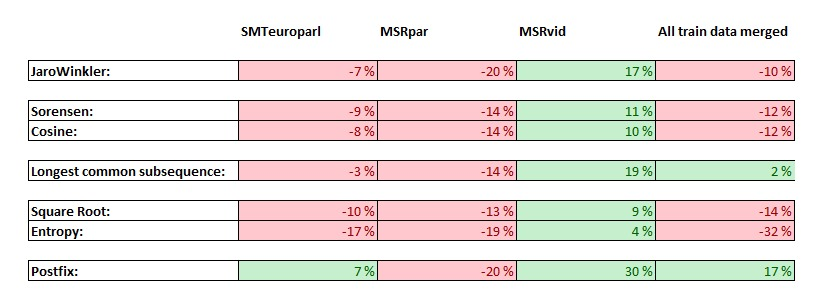

These values not only demonstrate the referred instability depending on the dataset but also the discrepancy between the validation and testing correlations since, with the exception of Postfix and longest common subsequence, all of the models decreased their performance.

According to the value obtained in the code, it is inferable that the model performs in the top 10 participants (over .7562).

The correlation related to the features (in all the datatsets merged) are the following:
*   Only Lexical Features: 0.7514
*   Only Syntactic Features: 0.7328
*   **Total Features: 0.7608**

Which indicates the importance of having both lexical and syntactic features. Furthermore, as expected, the correlation is higher with the lexical than the syntactic, since the importance is higher in the overall model, as analysed previously.

Furthermore, the correlation per dataset with all the features considered is:
1. STS.input.SMTeuroparl.txt: 0.7678
2. STS.input.MSRvid.txt: 0.7955
3. STS.input.MSRpar.txt: 0.7827
4. STS.input.surprise.SMTnews.txt: 0.5308
5. STS.input.surprise.OnWN.txt: 0.7166
6. **Total Datasets: 0.7608**

According to these values, it is noticeable that the model generalizes better on the three first datasets since these are also represented with a training set. On the other hand, in the surprise data, the domain shift is higher. Consequentially, the capacity of the model to generalize decreases specially in STS.input.surprise.SMTnews.txt.

# Conclusion

All the goals initially proposed were achieved with success and will be explained during the conclusion.

Firstly, it was comprehended that it is important to consider a set of features considerably distinct, in order to represent the information from the sentences in various ways. Overall, lexical and syntactic features are a good complement and generate more benefits when combined together.

Nonetheless, the main purpose is to get the most important features that describe the sentences, because as was seen in the feature selection, not all forms of representation are important.

Furthermore, considering models that belong to different categories, means that the type of information extracted is different. This way, it is possible to achieve distinct interpretations, that when combined allow for some generalization. However, this generalization decreases when the domain shift is large.

Finally, possible reasons for not achieving a higher score might be missing important features about the sentences, the models used limitations in the information extraction and even the supervised model selected, which can lack some generalization ability.

To conclude, the main purpose of the project was achieved successfully, always leaving room for improvement in distinct areas.

# Bibliography

*   ActiveWizards (2022). *Comparison of the Text Distance Metrics*. USA: KDnuggets.

*   Jason Brownlee (2021) *XGBoost for Regression*. USA: Machine Learning Mastery.
